# *dandelion* Notebook-3
![dandelion_logo](img/dandelion_logo.png)

# BCR clustering and visualization

Now that we have both 1) a pre-processed BCR data and 2) matching `AnnData` object, we can start finding clones and *'integrate'* the results. All the BCR analyses files can be saved as *.tsv* format so that it can be used in other tools like *immcantation*, *immunoarch*, *vdjtools*, etc.

On the topic of finding clones, there are many ways used for identifying BCR clones, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) to group clones based on the distribution of length-normalised junctional hamming distance while [rbr1](https://www.well.ox.ac.uk/research/research-groups/bashford-rogers) developed a method to use the whole BCR VDJ sequence to define clones as shown in this recent [paper](https://www.nature.com/articles/s41586-019-1595-3.pdf). While these methods have mainly been applied to bulk BCR-seq protocols, they are biological grounded and should be applicable to single cells.

# Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `tl.find_clones`. 

Clone definition is based on the following criterias:

    (1) Identical IGH V-J gene usage.

    (2) Identical CDR3 junctional sequence length.

    (3) CDR3 Junctional sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%).

    (4) Light chain usage. If cells within clones use different light chains, the clone will be splitted following the same conditions for heavy chains in (1-3) as above. 

The 'clone_id' name follows a `{A}_{B}_{C}_{D}` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same IGH V/J genes.
    
    {B} indicates if IGH junctional sequences are equal in length.
    
    {C} indicates if clones are splitted based on junctional hamming distance threshold
    
    {D} indicates light chain pairing. 

The last position will not be annotated if there's only one group of light chains usage detected in the clone.

#### Import modules

In [1]:
import os
import pandas as pd
os.chdir(os.path.expanduser('/Users/kt16/Documents/Github/dandelion'))
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc
sc.settings.verbosity = 3
import warnings
warnings.filterwarnings('ignore')

### Read in the previously saved files
I will work with the same example from the previous notebook since I have the `AnnData` object saved and vdj table filtered.

In [2]:
adata = sc.read_h5ad('adata.h5ad')
adata

AnnData object with n_obs × n_vars = 16492 × 1497
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'leiden'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'bcr_QC_pass_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
vdj = ddl.read_h5('dandelion_results.h5')
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

### Quick primer to the *Dandelion* class
So far, we have been operating with the `Dandelion` class:

In [4]:
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

Essentially, the `.data` slot holds the AIRR contig table while the `.metadata` holds a collapsed version that is compatible with combining with `AnnData`'s `.obs` slot. The other slots will be gradually filled as we go through the notebook. You can retrieve these slots like a typical class object; for example, if I want the metadata:

In [5]:
vdj.metadata

sample_id isotype  \
cell_id                                                               
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG      sc5p_v2_hs_PBMC_1k     IgM   
...                                                     ...     ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG  vdj_nextgem_hs_pbmc3     IgM   

                                      lightchain     status vdj_status  \
cell_id                                                                  
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG          IgL  IGH + IGL     Single   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG          IgK  IGH + IGK     Single   
...                                          ...        ...        ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT        IgK  IGH + IGK     Single   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA        IgL  IGH + IGL     Single   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT        IgL  IGH + IGL     Single   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA        IgK  IGH + IGK     Single   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG        IgL  IGH + IGL     Single   

                                      productive  umi_counts_heavy  \
cell_id                                                              
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG            T                17   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC            T                25   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG            T                41   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC            T                24   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG            T                34   
...                                          ...               ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT          T                14   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA          T                31   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT          T                16   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA          T                30   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG          T                40   

                                      umi_counts_light v_call_heavy  \
cell_id                                                               
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG               34.0     IGHV3-15   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC               36.0     IGHV3-30   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG               41.0     IGHV1-18   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC               37.0     IGHV3-23   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG               53.0     IGHV1-18   
...                                                ...          ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT             65.0     IGHV4-59   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA             38.0      IGHV3-7   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT              4.0     IGHV2-26   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA             38.0     IGHV1-18   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG             83.0      IGHV2-5   

                                             v_call_light j_call_heavy  \
cell_id                                                                  
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG               IGLV3-1        IGHJ4   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC              IGKV3-20        IGHJ6   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGG

You can deep copy the `Dandelion` object to another variable which will inherit all slots:

In [6]:
vdj2 = vdj.copy()
vdj2.metadata

sample_id isotype  \
cell_id                                                               
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC      sc5p_v2_hs_PBMC_1k     IgM   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG      sc5p_v2_hs_PBMC_1k     IgM   
...                                                     ...     ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA  vdj_nextgem_hs_pbmc3     IgM   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG  vdj_nextgem_hs_pbmc3     IgM   

                                      lightchain     status vdj_status  \
cell_id                                                                  
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG          IgL  IGH + IGL     Single   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC          IgK  IGH + IGK     Single   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG          IgK  IGH + IGK     Single   
...                                          ...        ...        ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT        IgK  IGH + IGK     Single   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA        IgL  IGH + IGL     Single   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT        IgL  IGH + IGL     Single   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA        IgK  IGH + IGK     Single   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG        IgL  IGH + IGL     Single   

                                      productive  umi_counts_heavy  \
cell_id                                                              
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG            T                17   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC            T                25   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG            T                41   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC            T                24   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG            T                34   
...                                          ...               ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT          T                14   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA          T                31   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT          T                16   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA          T                30   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG          T                40   

                                      umi_counts_light v_call_heavy  \
cell_id                                                               
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG               34.0     IGHV3-15   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC               36.0     IGHV3-30   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG               41.0     IGHV1-18   
sc5p_v2_hs_PBMC_1k_ACACCGGGTTATTCTC               37.0     IGHV3-23   
sc5p_v2_hs_PBMC_1k_ACCTTTAAGACAAAGG               53.0     IGHV1-18   
...                                                ...          ...   
vdj_nextgem_hs_pbmc3_TTGCGTCTCGTAGGTT             65.0     IGHV4-59   
vdj_nextgem_hs_pbmc3_TTTATGCTCCGCATAA             38.0      IGHV3-7   
vdj_nextgem_hs_pbmc3_TTTATGCTCTGATTCT              4.0     IGHV2-26   
vdj_nextgem_hs_pbmc3_TTTGCGCCACCATGTA             38.0     IGHV1-18   
vdj_nextgem_hs_pbmc3_TTTGCGCTCCAGTATG             83.0      IGHV2-5   

                                             v_call_light j_call_heavy  \
cell_id                                                                  
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG               IGLV3-1        IGHJ4   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC              IGKV3-20        IGHJ6   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGG

## Running `tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object (described in next section). The default mode for calculation of junctional hamming distance is to use the junction amino acid sequences. If you want to do it via nucleotide, you can specify the option:
```python
clustering_by = 'nt'
```

If you want to use the alleles for defining V-J gene usuage, specify:
```python
by_alleles = True
```

In [7]:
ddl.tl.find_clones(vdj)

Finding clones


Finding clones based on heavy chains : 100%|██████████| 176/176 [00:00<00:00, 2771.62it/s]
Refining clone assignment based on light chain pairing : 100%|██████████| 819/819 [00:00<00:00, 1846.25it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:01)


In [8]:
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

This will return a new column with the column name `'clone_id'` as per convention. If a filepath is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, if a `Dandelion` object or `pandas.DataFrame` is provided it will just be returned as a `Dandelion` object.

## Alternative : Running `tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `pp.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. Again, `pp.calculate_threshold` will take a file path, pandas `DataFrame` or `Dandelion` object as input. If a dandelion object is provided, the threshold value will be inserted into the `.threshold` slot. For more fine control, please use the `DefineClones.py` function [directly](https://immcantation.readthedocs.io/en/stable/tutorials/10x_tutorial.html).

### *pp.calculate_threshold*

Calculating threshold


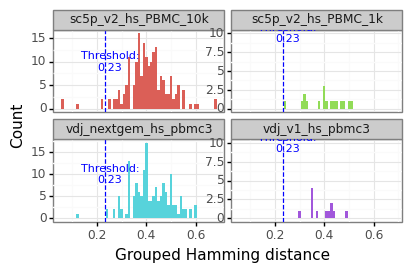

<ggplot: (368565545)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:46)


In [9]:
ddl.pp.calculate_threshold(vdj)

In [10]:
# see the actual value in .threshold slot
vdj.threshold

0.23211012088477453

You can also manually select a value as the threshold if you wish.

Calculating threshold


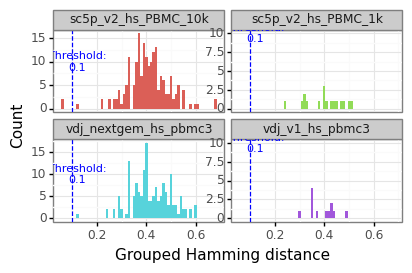

<ggplot: (363772577)>
 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:32)


In [11]:
ddl.pp.calculate_threshold(vdj, manual_threshold = 0.1)

In [12]:
# see the updated .threshold slot
vdj.threshold

0.1

### *tl.define_clones*

We can run `tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. Note, if a `pandas.DataFrame` or file path is provided as the input, the value in dist option (corresponds to threshold value) needs to be manually supplied. If a `Dandelion` object is provided, it will automatically retrieve it from the threshold slot. 

In [13]:
ddl.tl.define_clones(vdj, key_added = 'changeo_clone_id')

Finding clones
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:06)


Note that I specified the option `key_added` and this adds the output from `tl.define_clones` into a separate column. If left as default (`None`), it will write into `clone_id` column. The same option can be specified in `tl.find_clones` earlier. If there is an existing column for `clone_id`, the group column for the new key would not be computed; If you want to extract the grouped column, simply run define clones without key_added to replace the existing `clone_id` and `clone_id_group` columns.

## *update_metadata*
The `.metadata` slot in Dandelion class automatically initializes whenever the `.data` slot is filled. However, it only returns a standard number of columns that are pre-specified. To retrieve other columns in the `.data` slot, we can update the metadata with `ddl.update_metadata` and specify the option `retrieve`. you can also pass `collapse = True` and `split_heavy_light = False` if the two columns can be reasonably combined for that cell/barcode.

#### Example #1 : editing and updating clone id
If we want to collapse the clones based on just heavy chain contigs:

In [14]:
# using a list comprehension to remove the light chain clone assignment 
vdj.data['clone_id_heavyonly'] = [x.rsplit('_', 1)[0] if x.count('_') == 3 else x for x in vdj.data['clone_id']]
ddl.update_metadata(vdj, retrieve = 'clone_id_heavyonly', split_heavy_light = False, collapse = True)
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

#### Example #2 : retrieving junction amino acid sequences

In [15]:
ddl.update_metadata(vdj, retrieve = 'junction_aa')
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

Note the additional `junction_aa` columns in the metadata slot.

## Visualization of BCR network
*dandelion* generates a network to facilitate visualisation of results. This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone. The actual visualization will be achieved through `scanpy` later.

### *tl.generate_network*
First we need to generate the network. The tool function `tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone_id'` column. The default mode is to use amino acid sequences for constructing Levenshtein distance matrices.

If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *AIRR* format, the table can be used as well.

You can specify the `clone_key` option for generating the network for the clone id definition of choice as long as it exists as a column in the `.data` slot.

In [16]:
ddl.tl.generate_network(vdj)

Generating network


Linking edges : 100%|██████████| 821/821 [00:00<00:00, 5046.37it/s]


generating network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:10)


This step works reasonably fast here but will take quite a while when a lot of contigs are provided.

You can also downsample the number of cells. This will return a new object as a downsampled copy of the original with it's own distance matrix.

In [17]:
vdj_downsample = ddl.tl.generate_network(vdj, downsample = 500)
vdj_downsample

Generating network
Downsampling to 500 cells.


Linking edges : 100%|██████████| 490/490 [00:00<00:00, 6028.12it/s]


generating network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
   'distance', heavy and light chain distance matrices
   'edges', network edges
   'layout', network layout
   'graph', network (0:00:05)


Dandelion class object with n_obs = 500 and n_contigs = 1012
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

##### check the newly re-initialized Dandelion object

In [18]:
vdj

Dandelion class object with n_obs = 838 and n_contigs = 1700
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start',

The graph/networks can be accessed through the `.graph` slot as an `networkx` graph object if you want to extract the data for network statistics or make any changes to the network.

## Integration with scanpy
The results can also be ported into the `AnnData` object for access to more plotting functions provided through `scanpy`.

#### *tl.transfer*

To proceed, we first need to initialise the `AnnData` object with our network. This is done by using the tool function `tl.transfer`.

In [19]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True
adata

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:22)


AnnData object with n_obs × n_vars = 16492 × 1497
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'leiden', 'sample_id', 'clone_id', 'clone_id_by_size', 'isotype', 'lightchain', 'status', 'vdj_status', 'productive', 'umi_counts_heavy', 'umi_counts_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'changeo_clone_id', 'clone_id_heavyonly', 'junction_aa_heavy', 'junction_aa_light'
    var: 'feature_types', 'genome', 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'bcr_QC_pass_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'rna_neighbors'
    obsm: 'X_pca', 'X_umap', 'X_bcr'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'rna_connecti

You can see that `AnnData` object now contains a couple more columns in the `.obs` slot, corresponding to the metadata that is returned after `tl.generate_network`, and newly populated `.obsm` and `.obsp` slots. The original RNA connectivities and distances are now added into the `.obsp` slot as well.

## Plotting in scanpy

### *pl.clone_network*
So now, basically we can plot in `scanpy` with their plotting modules. I've included a plotting function in ***dandelion***, `pl.clone_network`, which is really just a wrapper of their `pl.embedding` module.

... storing 'sample_id' as categorical
... storing 'clone_id' as categorical
... storing 'isotype' as categorical
... storing 'lightchain' as categorical
... storing 'status' as categorical
... storing 'vdj_status' as categorical
... storing 'productive' as categorical
... storing 'umi_counts_light' as categorical
... storing 'v_call_heavy' as categorical
... storing 'v_call_light' as categorical
... storing 'j_call_heavy' as categorical
... storing 'j_call_light' as categorical
... storing 'c_call_heavy' as categorical
... storing 'c_call_light' as categorical
... storing 'changeo_clone_id' as categorical
... storing 'clone_id_heavyonly' as categorical
... storing 'junction_aa_heavy' as categorical
... storing 'junction_aa_light' as categorical


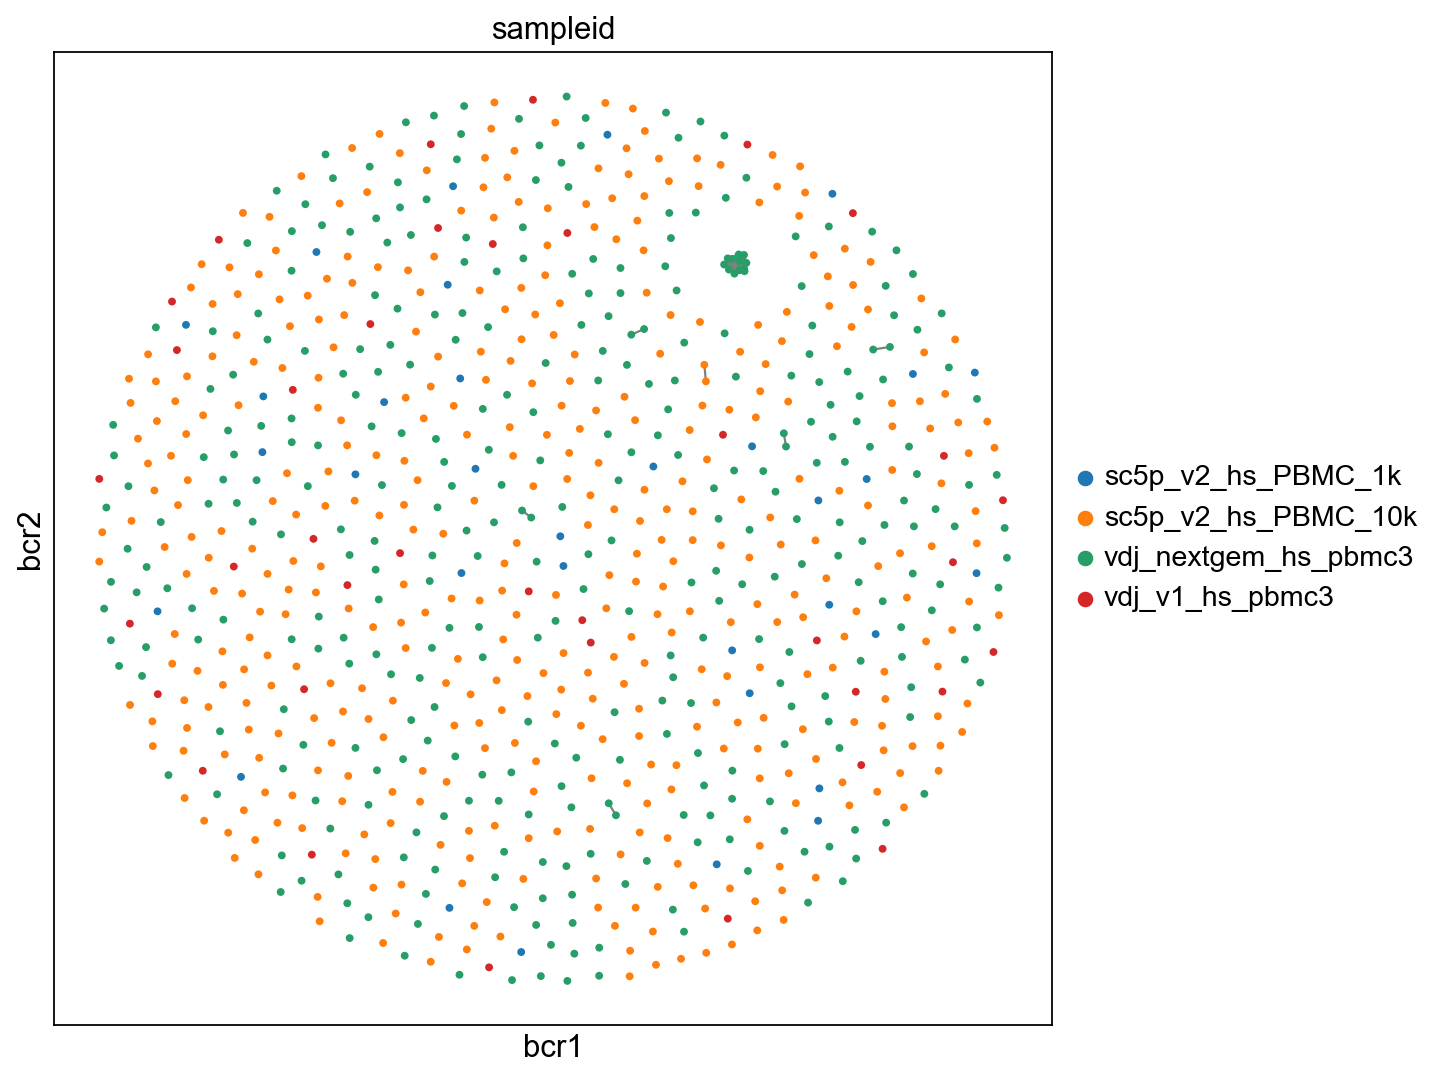

In [20]:
sc.set_figure_params(figsize = [8,8])
ddl.pl.clone_network(adata, 
                     color = ['sampleid'], 
                     edges_width = 1,
                     size = 50) 

***dandelion*** provides an edge weight extractor tool `tl.extract_edge_weights` to retrieve the edge weights that can be used to specify the edge widths according to weight/distance.

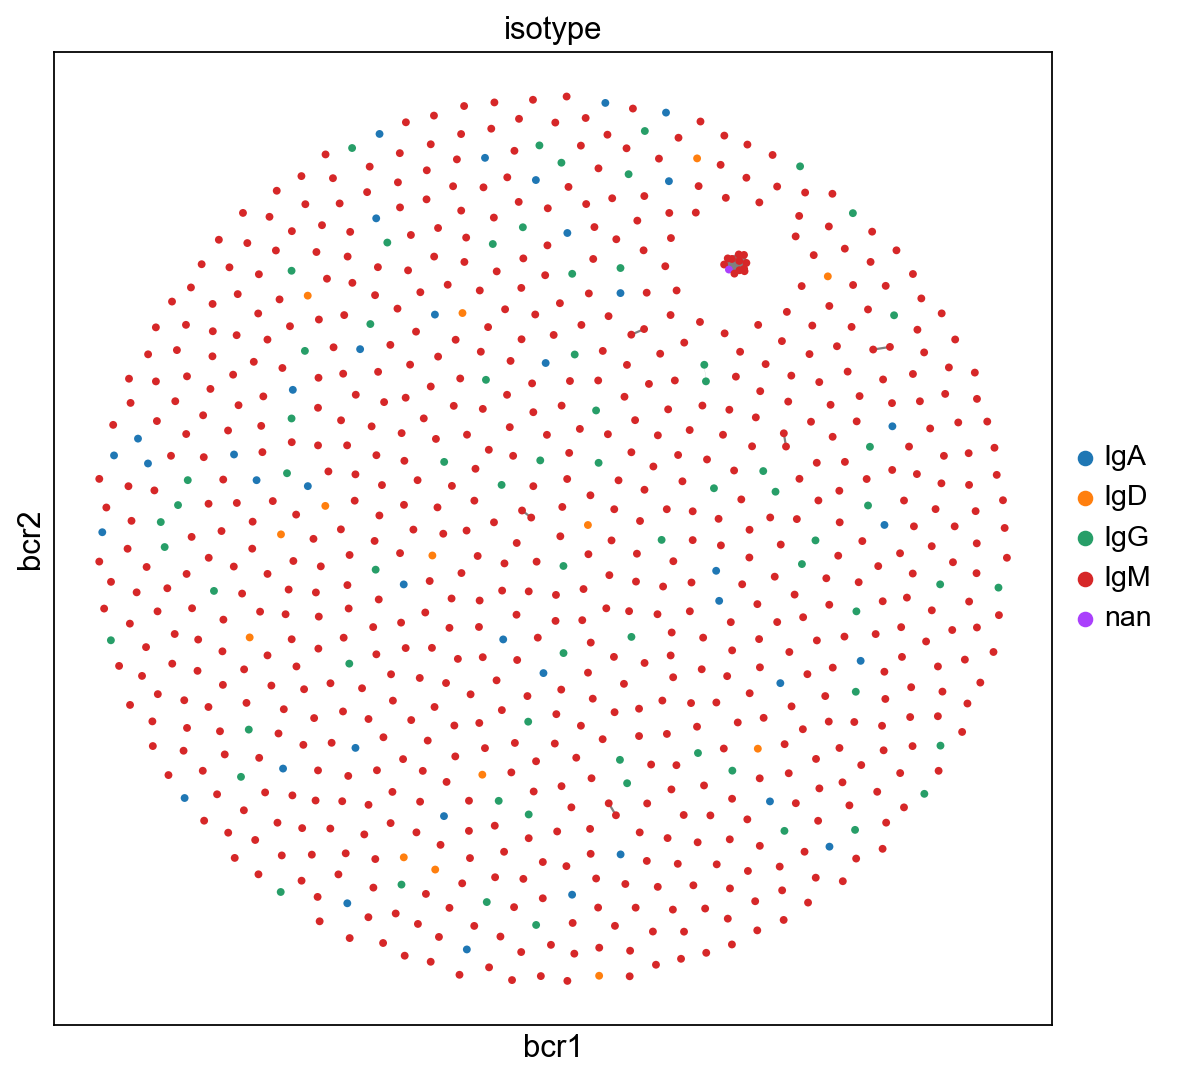

In [21]:
edgeweights = [1/(e+1) for e in ddl.tl.extract_edge_weights(vdj)] # add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
ddl.pl.clone_network(adata, 
                     color = ['isotype'], 
                     legend_fontoutline=3, 
                     edges_width = edgeweights,
                     size = 50) 

You can interact with `pl.clone_network` just as how you interact with the rest of the scatterplot modules in `scanpy`.

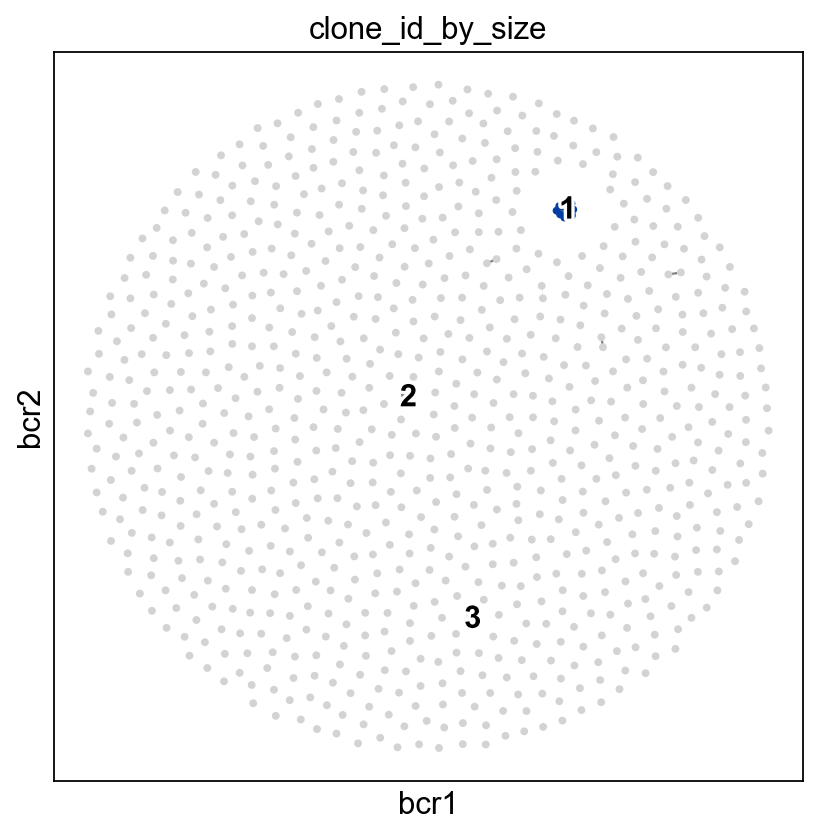

In [22]:
from scanpy.plotting.palettes import default_28, default_102
sc.set_figure_params(figsize = [6,6])
# plot the 3 largest clones by size
ddl.pl.clone_network(adata, color = ['clone_id_by_size'], groups = ['1', '2', '3'], ncols = 2, legend_loc = 'on data', legend_fontoutline=3, edges_width = edgeweights, size = 50, palette = default_28)

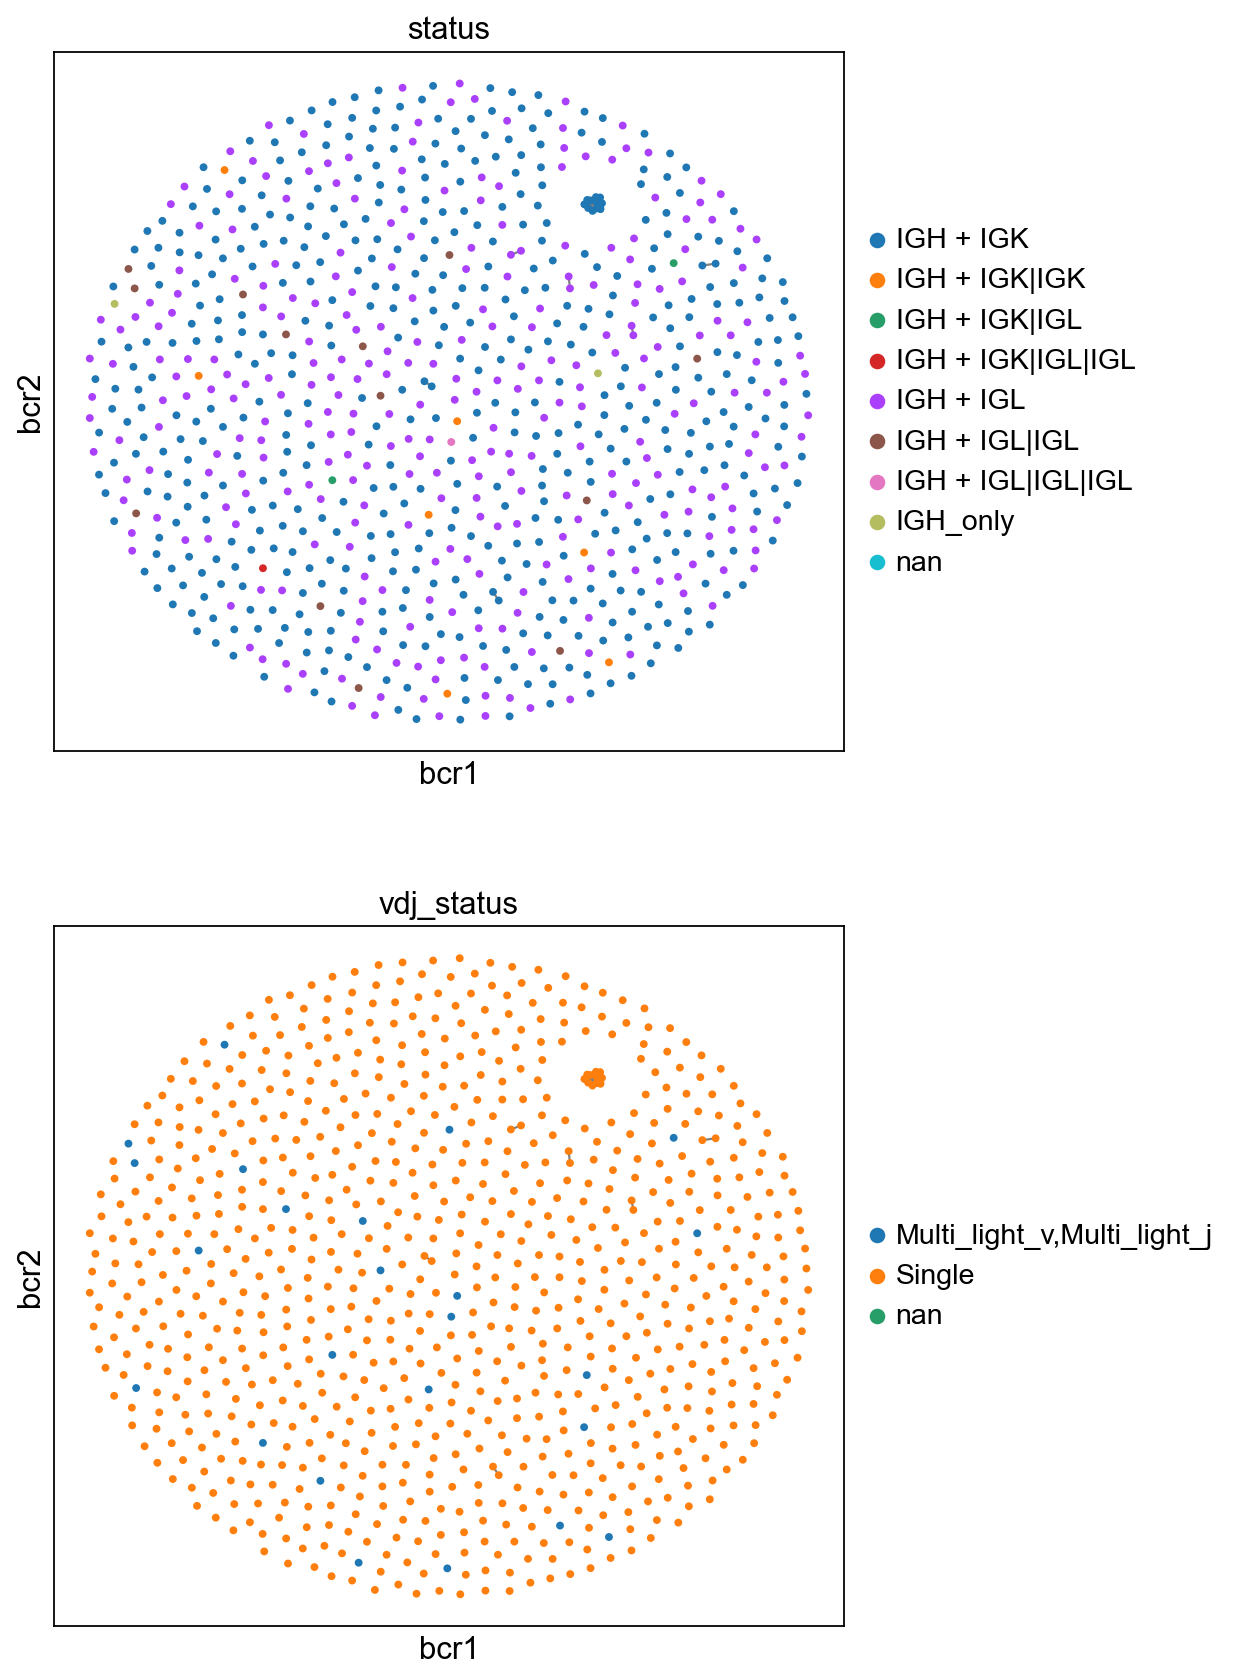

In [23]:
ddl.pl.clone_network(adata, color = ['status', 'vdj_status'], ncols = 1, legend_fontoutline=3, edges_width = 1, size = 50)

By specifying `expanded_only=True`, you will transfer the graph of only expanded clones (> 1 cell in a clone).

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:19)


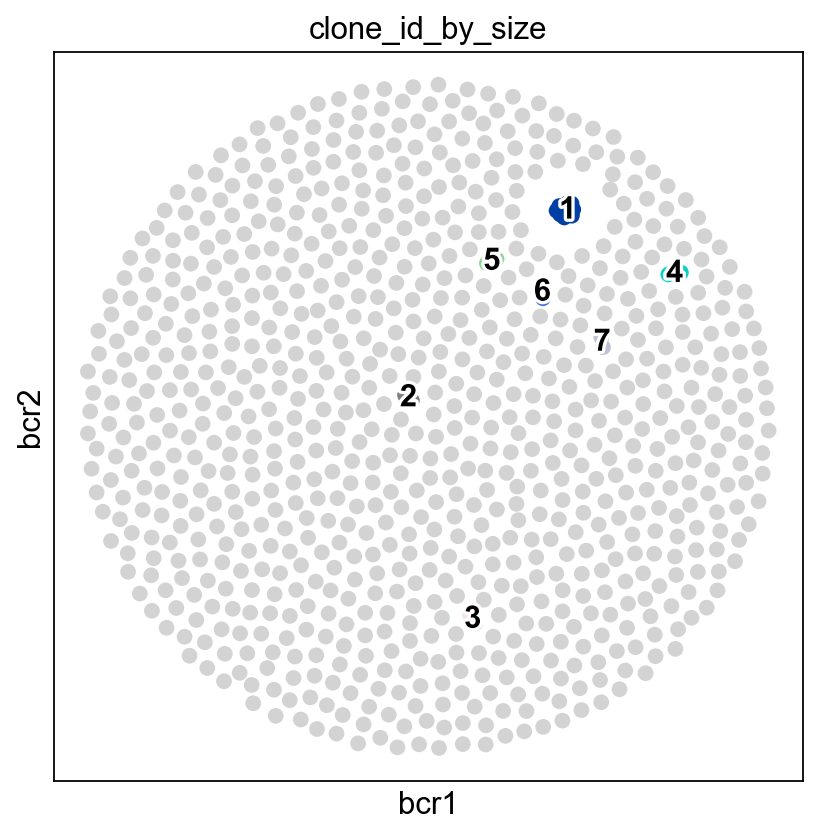

In [24]:
ddl.tl.transfer(adata, vdj)
edgeweights = [1/(e+1) for e in ddl.tl.extract_edge_weights(vdj)] # add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
ddl.pl.clone_network(adata, color = ['clone_id_by_size'], groups = ['1', '2', '3', '4', '5', '6', '7'], legend_loc = 'on data', legend_fontoutline=3, edges_width = edgeweights, size = 200)

### Calculating mutational load
To calculate mutational load, I've ported the functions from immcantation suite's changeo and shazam to work with the `dandelion` class object.

This can be run immediately after `pp.reassign_alleles` in notebook-1 because the required germline columns should be present in the genotyped `.tsv` file. I would reccomend to run this after TIgGER, after the v_calls were corrected.

But say you want to run it now instead, this can be achieved:

In [25]:
# let's recreate the vdj object with only the first two samples
subset_data = vdj.data[vdj.data['sample_id'].isin(['sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k'])]
subset_data

sequence_id  \
sequence_id                                                                                    
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1    sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1   
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2    sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1    sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2    sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1    sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1   
...                                                                                      ...   
sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1  sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2  sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1  sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1  sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2  sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2   

                                                                                        sequence  \
sequence_id                                                                                        
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1   CTGGGCCTCAGGAAGCAGCATCGGAGGTGCCTCAGCCATGGCATGG...   
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2   AGCTCTGGGAGAGGAGCCCCAGCCTTGGGATTCCCAAGTGTTTTCA...   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1   AGAGCTCTGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCAT...   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2   GAGCTCTGGGAGAGGAGCCCAGCACTAGAAGTCGGCGGTGTTTCCA...   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1   GAGCTACAACAGGCAGGCAGGGGCAGCAAGATGGTGTTGCAGACCC...   
...                                                                                          ...   
sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1  TTTCCTCTCTTCAACTGCGAACCGACTTTCTGCGATGGGGACTCAA...   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2  GGGAGAGCCCTGGGGAGGAACTGCTCAGTTAGGACCCAGAGGGAAC...   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1  ACAACCACACCCCTCCTAAGAAGAAGCCCCTAGACCACAGCTCCAC...   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1  GAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCACTTGGTG...   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2  GGGAGAGCCCTGGGGAGGAACTGCTCAGTTAGGACCCAGAGGGAAC...   

                                              rev_comp productive  \
sequence_id                                                         
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1         F          T   
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2         F          T   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1         F          T   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2         F          T   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1         F          T   
...                                                ...        ...   
sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2        F          T   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1        F          T   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2        F          T   

                                                                  v_call  \
sequence_id                                                                
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1                  IGLV3-1*01   
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2                 IGHV3-15*01   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1                 IGKV3-20*01   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2   IGHV3-30*02,IGHV3-30-5*02   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1                  IGKV4-1*01   
...                                                                  ...   
sc5p_v2_hs_PBMC_10k_TTTCC

In [26]:
# create a new Dandelion class with this subset
vdj2 = ddl.Dandelion(subset_data)
vdj2

Dandelion class object with n_obs = 454 and n_contigs = 926
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'c_call', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'v_call_genotyped', 'germline_alignment_d_mask', 'sample_id', 'c_sequence_alignment', 'c_germline_alignment', 'c_sequence_start', 

In [27]:
# update the germline using the corrected files after tigger
vdj2.update_germline(corrected = 'tutorial_scgp1/tutorial_scgp1_heavy_igblast_db-pass_genotype.fasta', germline = None, org = 'human')

Updating germline reference
 finished: Updated Dandelion object: 
   'germline', updated germline reference
 (0:00:00)


### *pp.create_germlines*

Then we run `pp.create_germline` to (re)create the `germline_alignment_d_mask` column in the data. If `update_germline` was run like above, there's no need to specify the `germline` option as the function will simply retrieve it from the `Dandelion` object.

*Note: the ability to run the original CreateGermlines.py with --cloned option is not currently possible through pp.create_germlines(). This is possible with pp.external.creategermlines but requires a physical file for CreateGermlines.py to work on. Thus, I would reccomend for you to run CreateGermlines.py separately if you intend to use the --cloned option. See [here](https://changeo.readthedocs.io/en/stable/examples/germlines.html) for more info.*

In [28]:
ddl.pp.create_germlines(vdj2, v_field = 'v_call_genotyped', germ_types='dmask')

Reconstructing germline sequences


   Building dmask germline sequences: 926it [00:01, 918.21it/s]


 finished: Updated Dandelion object: 
   'data', updated germline alignment in contig-indexed clone table
   'germline', updated germline reference
 (0:00:01)


Ensure that the germline_alignment_d_mask column is populated or subsequent steps will fail.

In [29]:
vdj2.data[['v_call_genotyped', 'germline_alignment_d_mask']]

v_call_genotyped  \
sequence_id                                                      
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1        IGLV3-1*01   
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2       IGHV3-15*01   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1       IGKV3-20*01   
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2       IGHV3-30*02   
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1        IGKV4-1*01   
...                                                        ...   
sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1       IGHV1-8*01   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2      IGKV3-11*01   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1     IGHV7-4-1*02   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1      IGHV3-21*01   
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2      IGKV3-11*01   

                                                                       germline_alignment_d_mask  
sequence_id                                                                                       
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_1   TCCTATGAGCTGACTCAGCCACCCTCA...GTGTCCGTGTCCCCAG...  
sc5p_v2_hs_PBMC_1k_AACTGGTTCTCTAAGG_contig_2   GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTAAAGCCTG...  
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_1   GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...  
sc5p_v2_hs_PBMC_1k_AATCCAGTCAGTTGAC_contig_2   CAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCGTGGTCCAGCCTG...  
sc5p_v2_hs_PBMC_1k_AATCGGTGTTAGGGTG_contig_1   GACATCGTGATGACCCAGTCTCCAGACTCCCTGGCTGTGTCTCTGG...  
...                                                                                          ...  
sc5p_v2_hs_PBMC_10k_TTTCCTCTCTTCAACT_contig_1  CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...  
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_2  GAAATTGTGTTGACACAGTCTCCAGCCACCCTGTCTTTGTCTCCAG...  
sc5p_v2_hs_PBMC_10k_TTTGGTTTCAGAGCTT_contig_1  CAGGTGCAGCTGGTGCAATCTGGGTCT...GAGTTGAAGAAGCCTG...  
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_1  GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...  
sc5p_v2_hs_PBMC_10k_TTTGGTTTCGGTGTCG_contig_2  GAAATTGTGTTGACACAGTCTCCAGCCACCCTGTCTTTGTCTCCAG...  

[926 rows x 2 columns]

The default behaviour is to mask the D region with Ns with option `germ_types = 'dmask'`. See [here](https://changeo.readthedocs.io/en/stable/methods/germlines.html) for more info.

### *pp.quantify_mutations*
The options for `pp.quantify_mutations` are the same as the basic mutational load analysis [vignette](https://shazam.readthedocs.io/en/version-0.1.8---mutation-profiling-enhancements/vignettes/Mutation-Vignette/). The default behavior is to sum all mutations scores (heavy and light chains, silent and replacement mutations) for the same cell.

Again, this function can be run immediately after `pp.reassign_alleles` on the genotyped `.tsv` files (without loading into `pandas` or `Dandelion`). Here I'm illustrating a few other options that may be useful.

In [30]:
# switching back to using the full vdj object
ddl.pp.quantify_mutations(vdj)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:05)


In [31]:
ddl.pp.quantify_mutations(vdj, combine = False)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:04)


Specifying `split_locus = True` will split up the results for the different chains.

In [32]:
ddl.pp.quantify_mutations(vdj, split_locus = True)

Quantifying mutations
 finished: Updated Dandelion object: 
   'data', contig-indexed clone table
   'metadata', cell-indexed clone table
 (0:00:05)


To update the `AnnData` object, simply rerun `tl.transfer_network` with keep_raw option set to `False` to avoid overwriting the stashed neighborhood graph.

In [33]:
ddl.tl.transfer(adata, vdj)

Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:16)


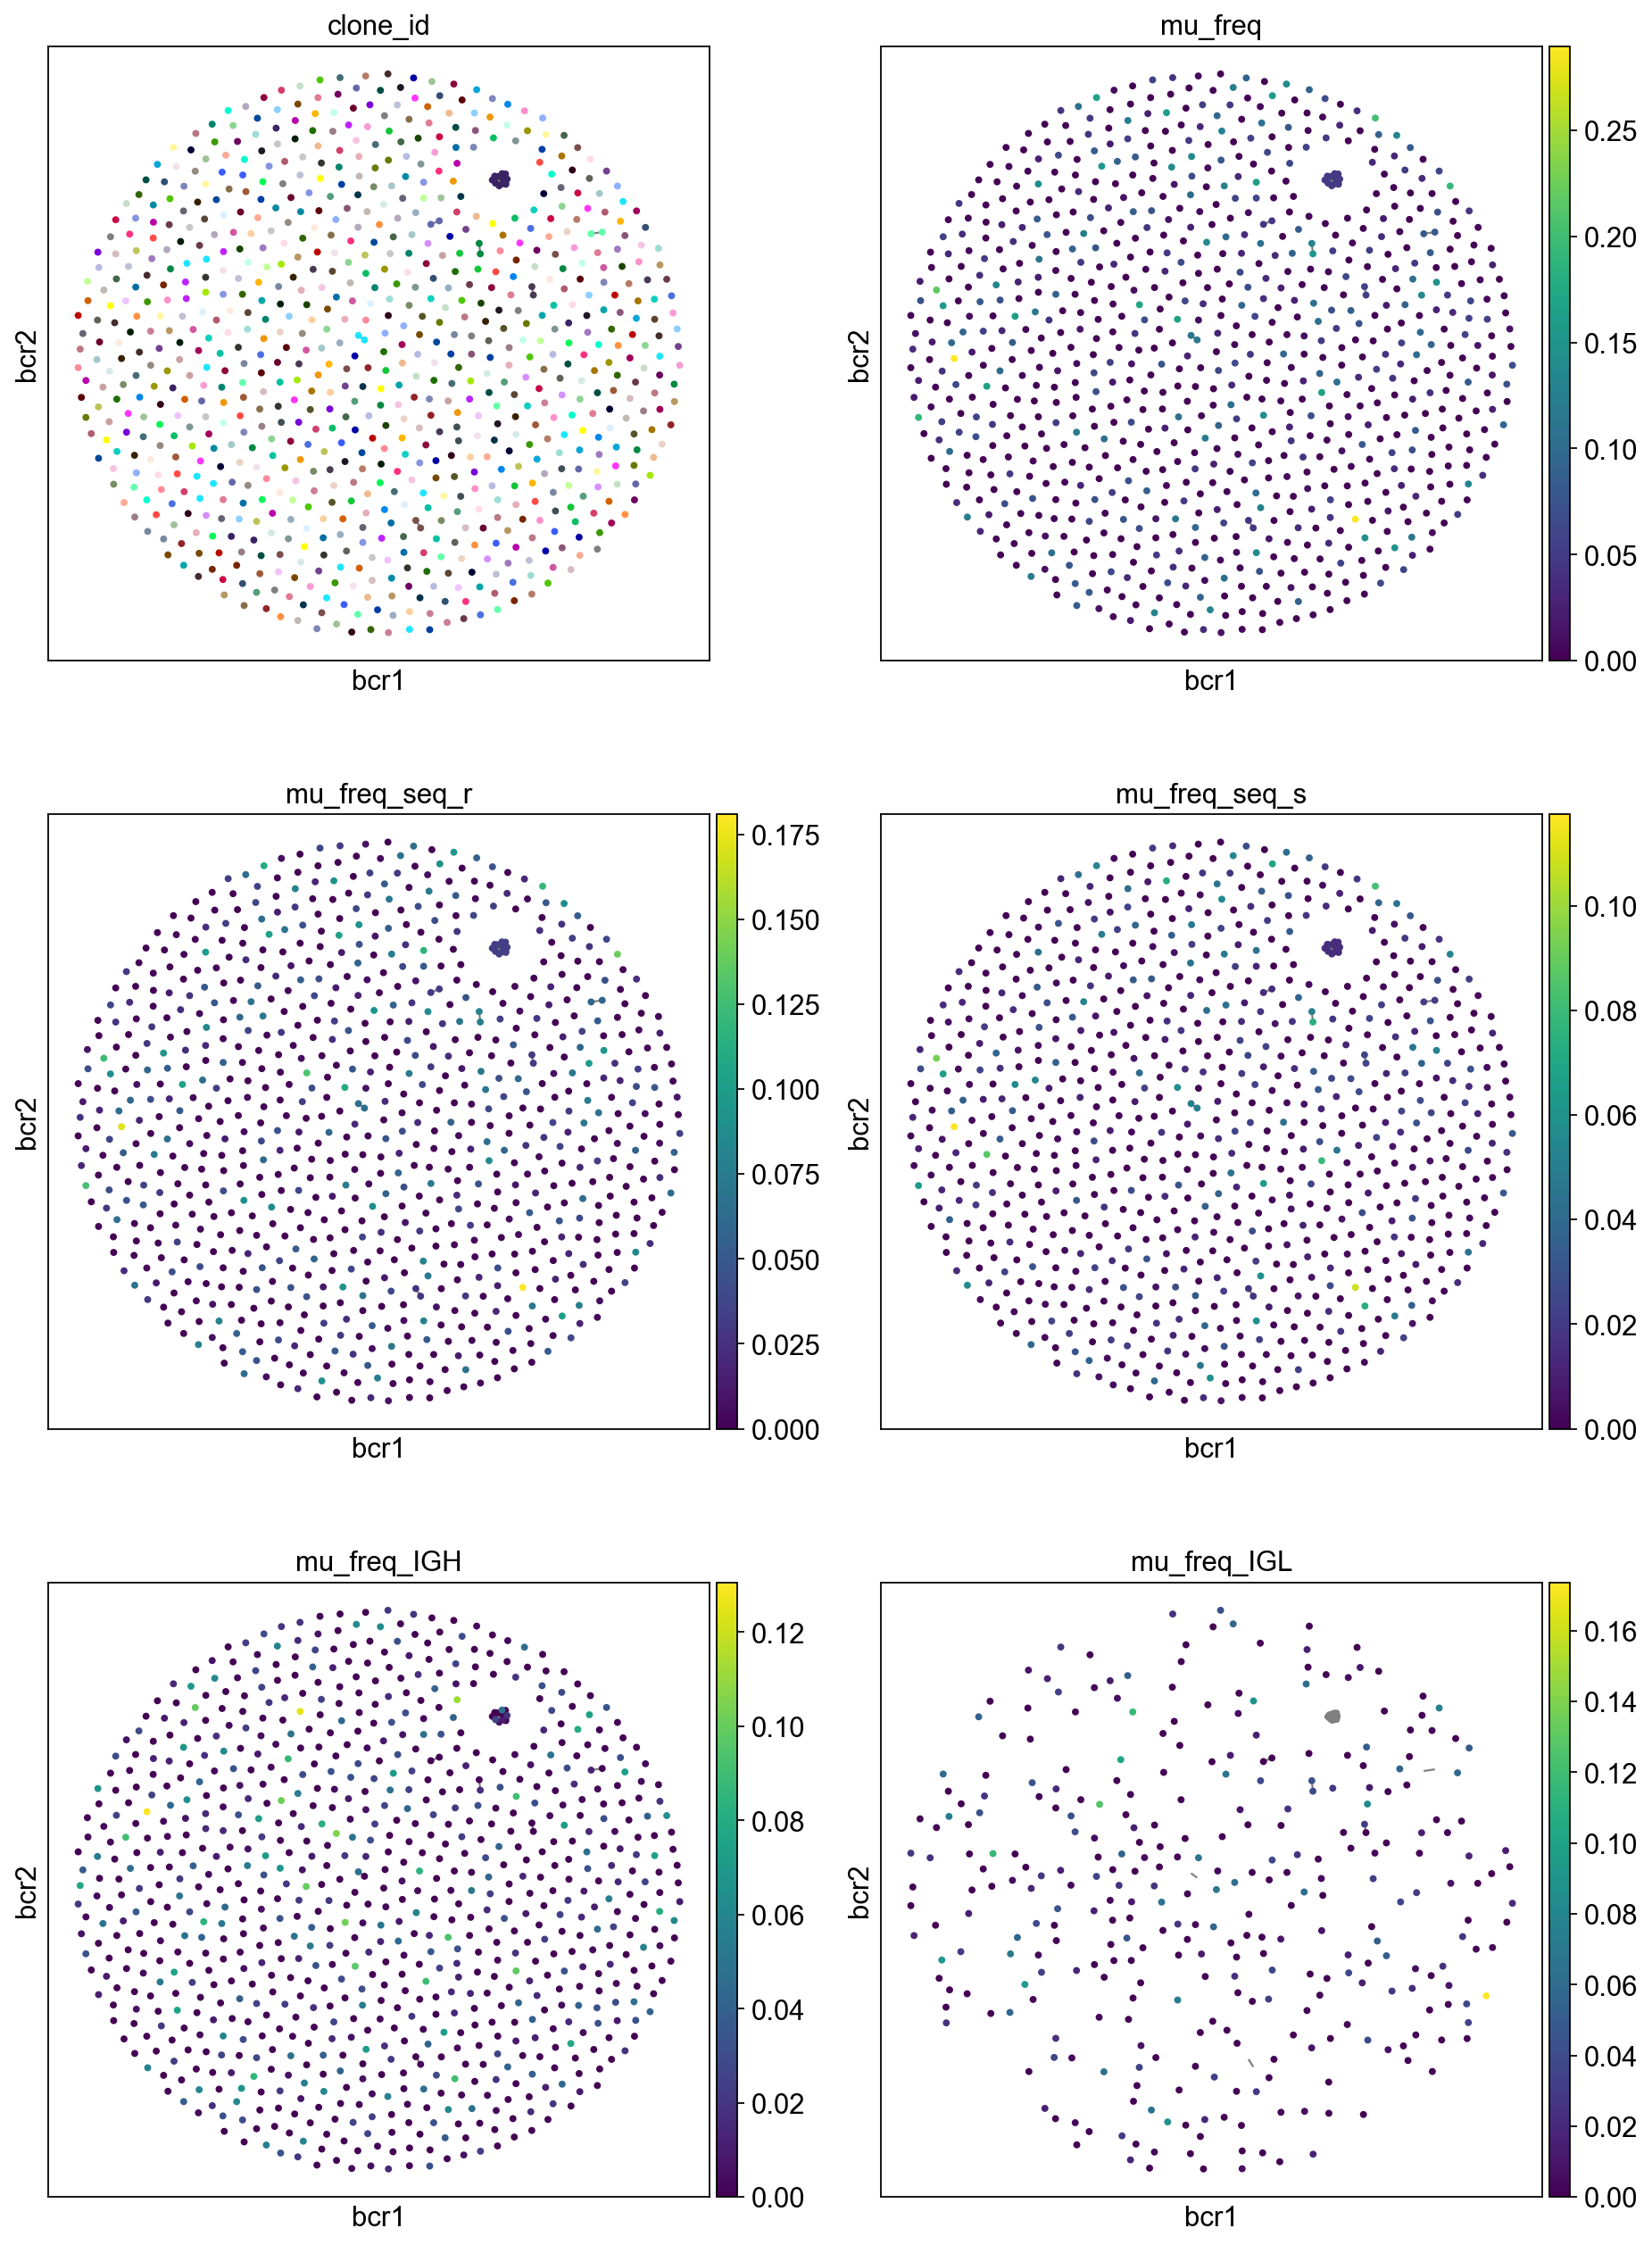

In [34]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, color = ['clone_id', 'mu_freq', 'mu_freq_seq_r', 'mu_freq_seq_s', 'mu_freq_IGH', 'mu_freq_IGL'], ncols = 2, legend_loc = 'none', legend_fontoutline=3, edges_width = 1, palette = default_28 + default_102, color_map = 'viridis', size = 50)

## Calculating size of clones

### *tl.clone_size*

Sometimes it's useful to evaluate the size of the clone. Here `tl.quantify_clone_size` does a simple calculation to enable that.

In [35]:
ddl.tl.clone_size(vdj)
ddl.tl.transfer(adata, vdj)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:17)


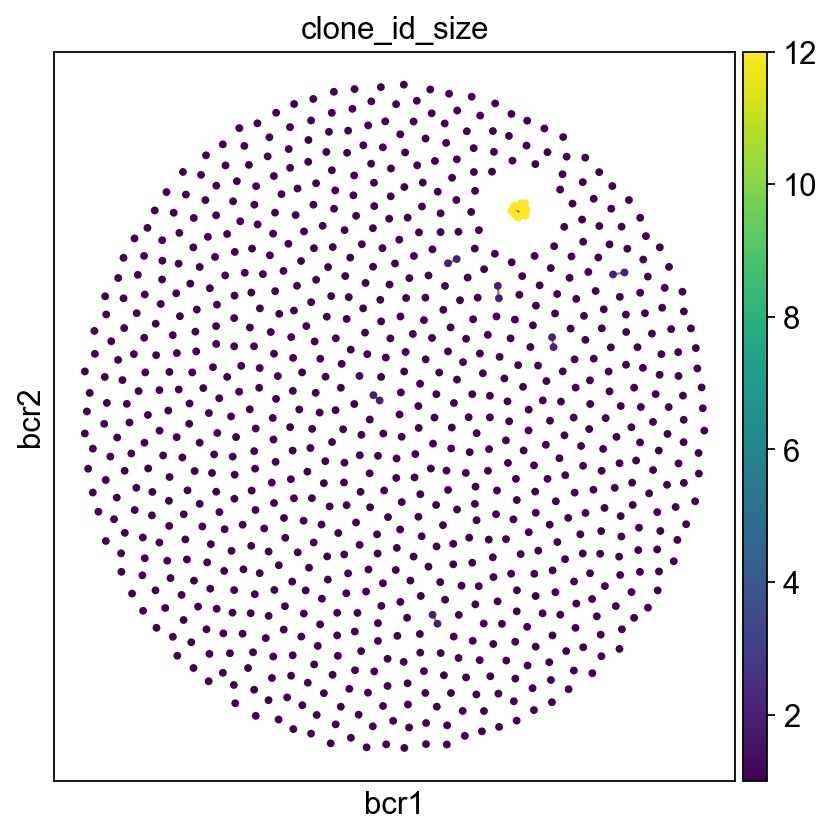

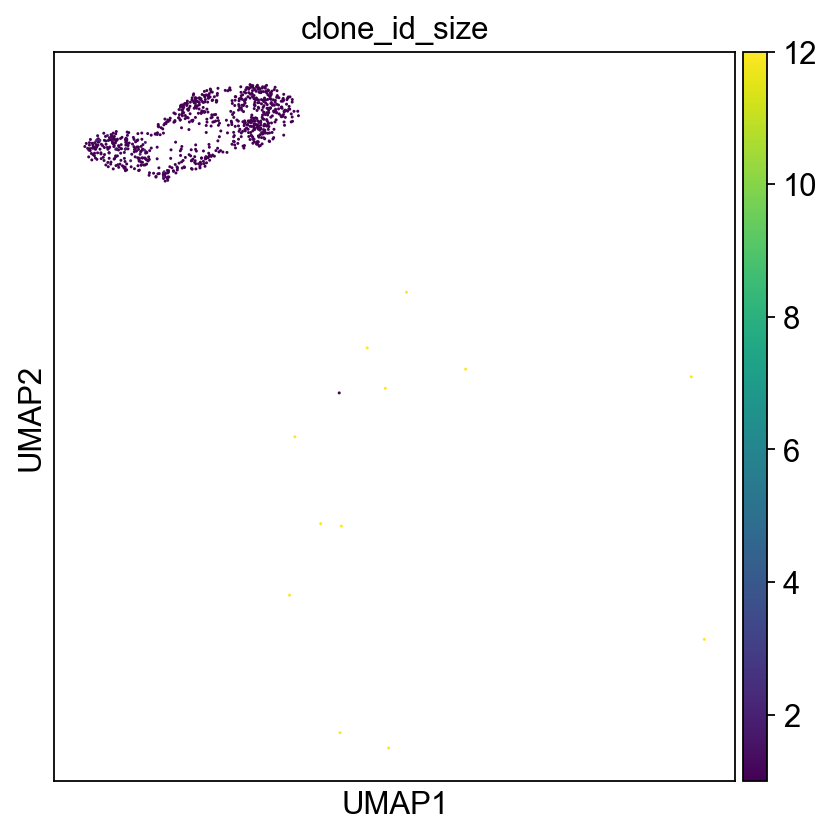

In [36]:
ddl.pl.clone_network(adata, color = ['clone_id_size'], legend_loc = 'none', legend_fontoutline=3, edges_width = 1, size = 50)
sc.pl.umap(adata, color = ['clone_id_size'])

You can also specify `max_size` to clip off the calculation at a fixed value.

In [37]:
ddl.tl.clone_size(vdj, max_size = 3)
ddl.tl.transfer(adata, vdj)

Quantifying clone sizes
 finished: Updated Dandelion object: 
   'metadata', cell-indexed clone table (0:00:00)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:17)


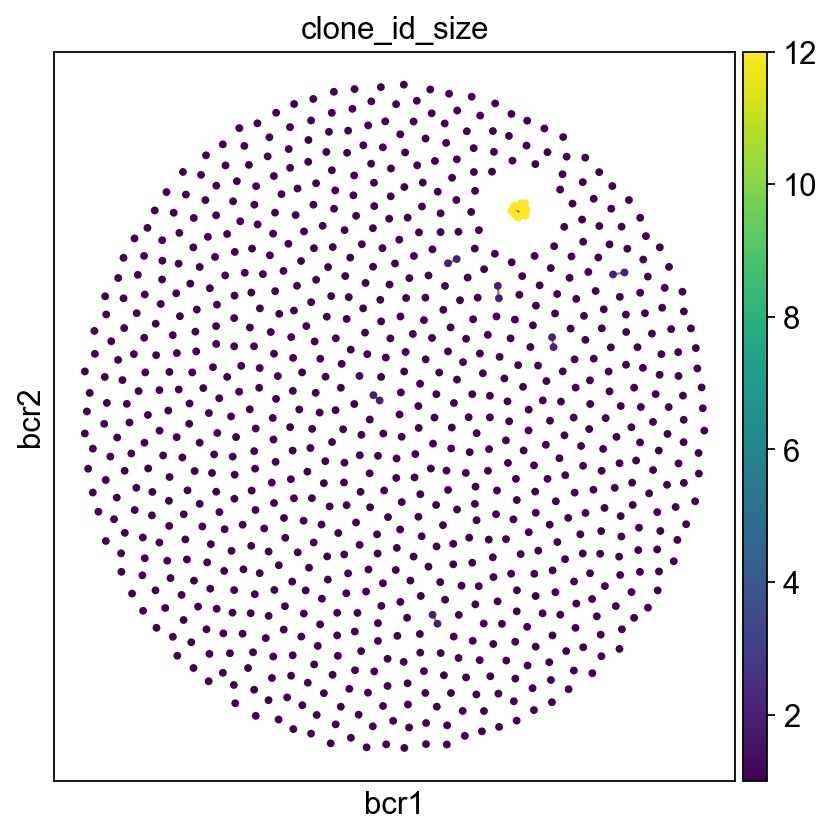

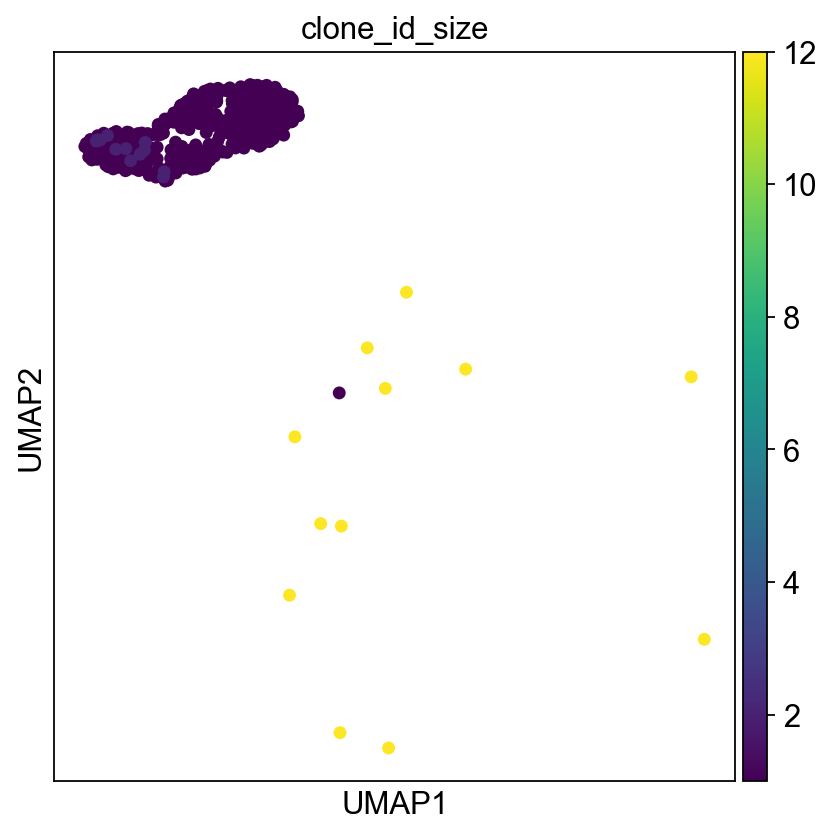

In [38]:
ddl.pl.clone_network(adata, color = ['clone_id_size'], ncols = 2, legend_fontoutline=3, edges_width = 1, palette = ['grey', 'red', 'blue', 'white'], size = 50)
sc.pl.umap(adata[adata.obs['has_bcr'] == 'True'], color = ['clone_id_size'], palette = ['grey', 'red', 'blue', 'white'])

## Calculating diversity

*disclaimer: the functions here are not complete yet. Please look to other sources/methods for doing this properly. Also, would appreciate any help to help me finalise this!* 

### *clone_rarefaction*

We can use `pl.clone_rarefaction` to generate rarefaction curves for the clones. `tl.clone_rarefaction` will populate the `.uns` slot with the results. `groupby` option must be specified. In this case, I decided to group by sample. The function will only work on an `AnnData` object and not a `Dandelion` object.

removing due to zero counts: 


Calculating rarefaction curve : 100%|██████████| 4/4 [00:00<00:00, 17.00it/s]


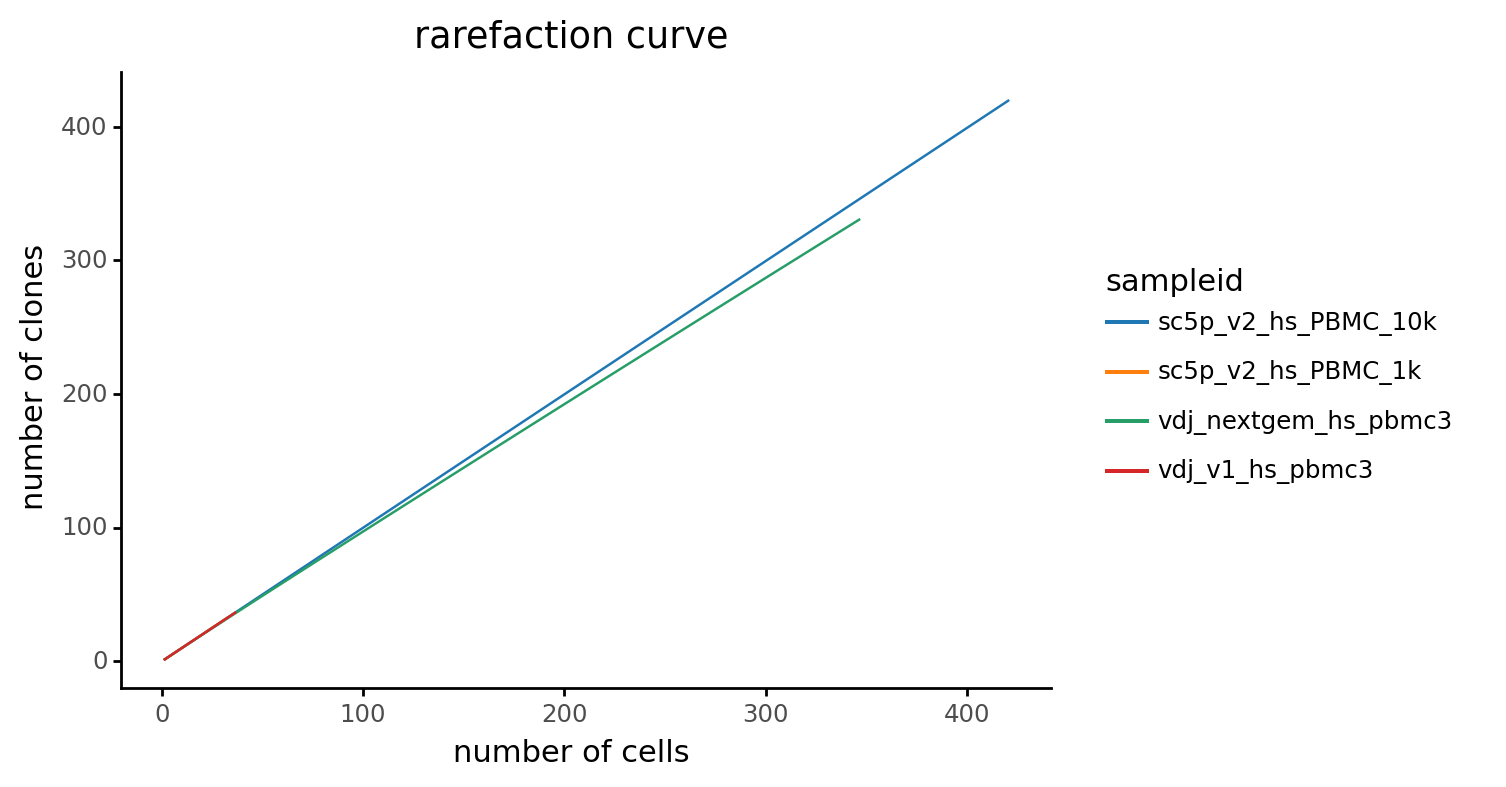

<ggplot: (374109445)>

In [39]:
ddl.pl.clone_rarefaction(adata, groupby = 'sampleid')

### *tl.clone_diversity*

`tl.clone_diversity` allows for calculation of diversity measures such as **Chao1**, **Shannon Entropy** and **Gini indices**. 

For Gini indices, we provide several types of measures:

***i) clone size Gini index***

This measure is always provided. Samples with large disparity in clone sizes are more mutated/clonal, rather than samples with evenly sized clones.

### default option
***ii) vertex size Gini index***

In a contracted BCR network (where identical BCRs are collapsed), samples with large disparity in vertex sizes are more clonal, rather than samples with evenly (small) spreaded vertex sizes.

In other words, a Gini index of 1 on either measures repesents perfect inequality (i.e. monoclonal and highly mutated) and a value of 0 represents perfect equality (i.e. polyclonal and unmutated).

### experimental options
***iii) clone centrality Gini index***

Node/vertex closeness centrality indicates how tightly packed clones are (more clonally related) and thus the distribution of the number of cells connected in each clone informs on whether clones in general are more monoclonal or polyclonal.

***iv) clone degree Gini index***

Node/vertex degree indicates how many cells are connected to an individual cell, another indication of how clonally related cells are. However, this would also highlight cells that are in the middle of large networks but are not necessarily within clonally expanded regions (e.g. intermediate connecting cells within the minimum spanning tree)

For iii) and iv), the current implementation will only calculate on expanded clones i.e. clones with at least 2 cells.

While the function can work on both `AnnData` and `Dandelion` objects, the network based gini measures will only work on a `Dandelion` object as it requires exccess to the network. 

The diversity functions also have the option to perform downsampling to a fixed number of cells, or to the smallest sample size specified via `groupby` (default) so that sample sizes are even when comparing between groups.

if `update_obs_meta=False`, a data frame is returned; otherwise, the value gets added to the `AnnData.obs` or `Dandelion.metadata` accordingly.

In [40]:
ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'gini', metric = 'clone_vertexsize')
ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'gini', metric = 'clone_centrality')
ddl.tl.transfer(adata, vdj)

Calculating Gini indices
Dandelion provided. Computing Gini indices for clone size and clone network.
 finished: updated `.metadata` with Gini indices.
 (0:00:12)
Calculating Gini indices
Dandelion provided. Computing Gini indices for clone size and clone network.
Calculating node closeness centrality
 finished: Updated Dandelion metadata
 (0:00:00)
 finished: updated `.metadata` with Gini indices.
 (0:00:01)
Transferring network
converting matrices
Updating anndata slots
 finished: updated `.obs` with `.metadata`
added to `.uns['neighbors']` and `.obsp`
   'distances', cluster-weighted adjacency matrix
   'connectivities', cluster-weighted adjacency matrix (0:00:16)


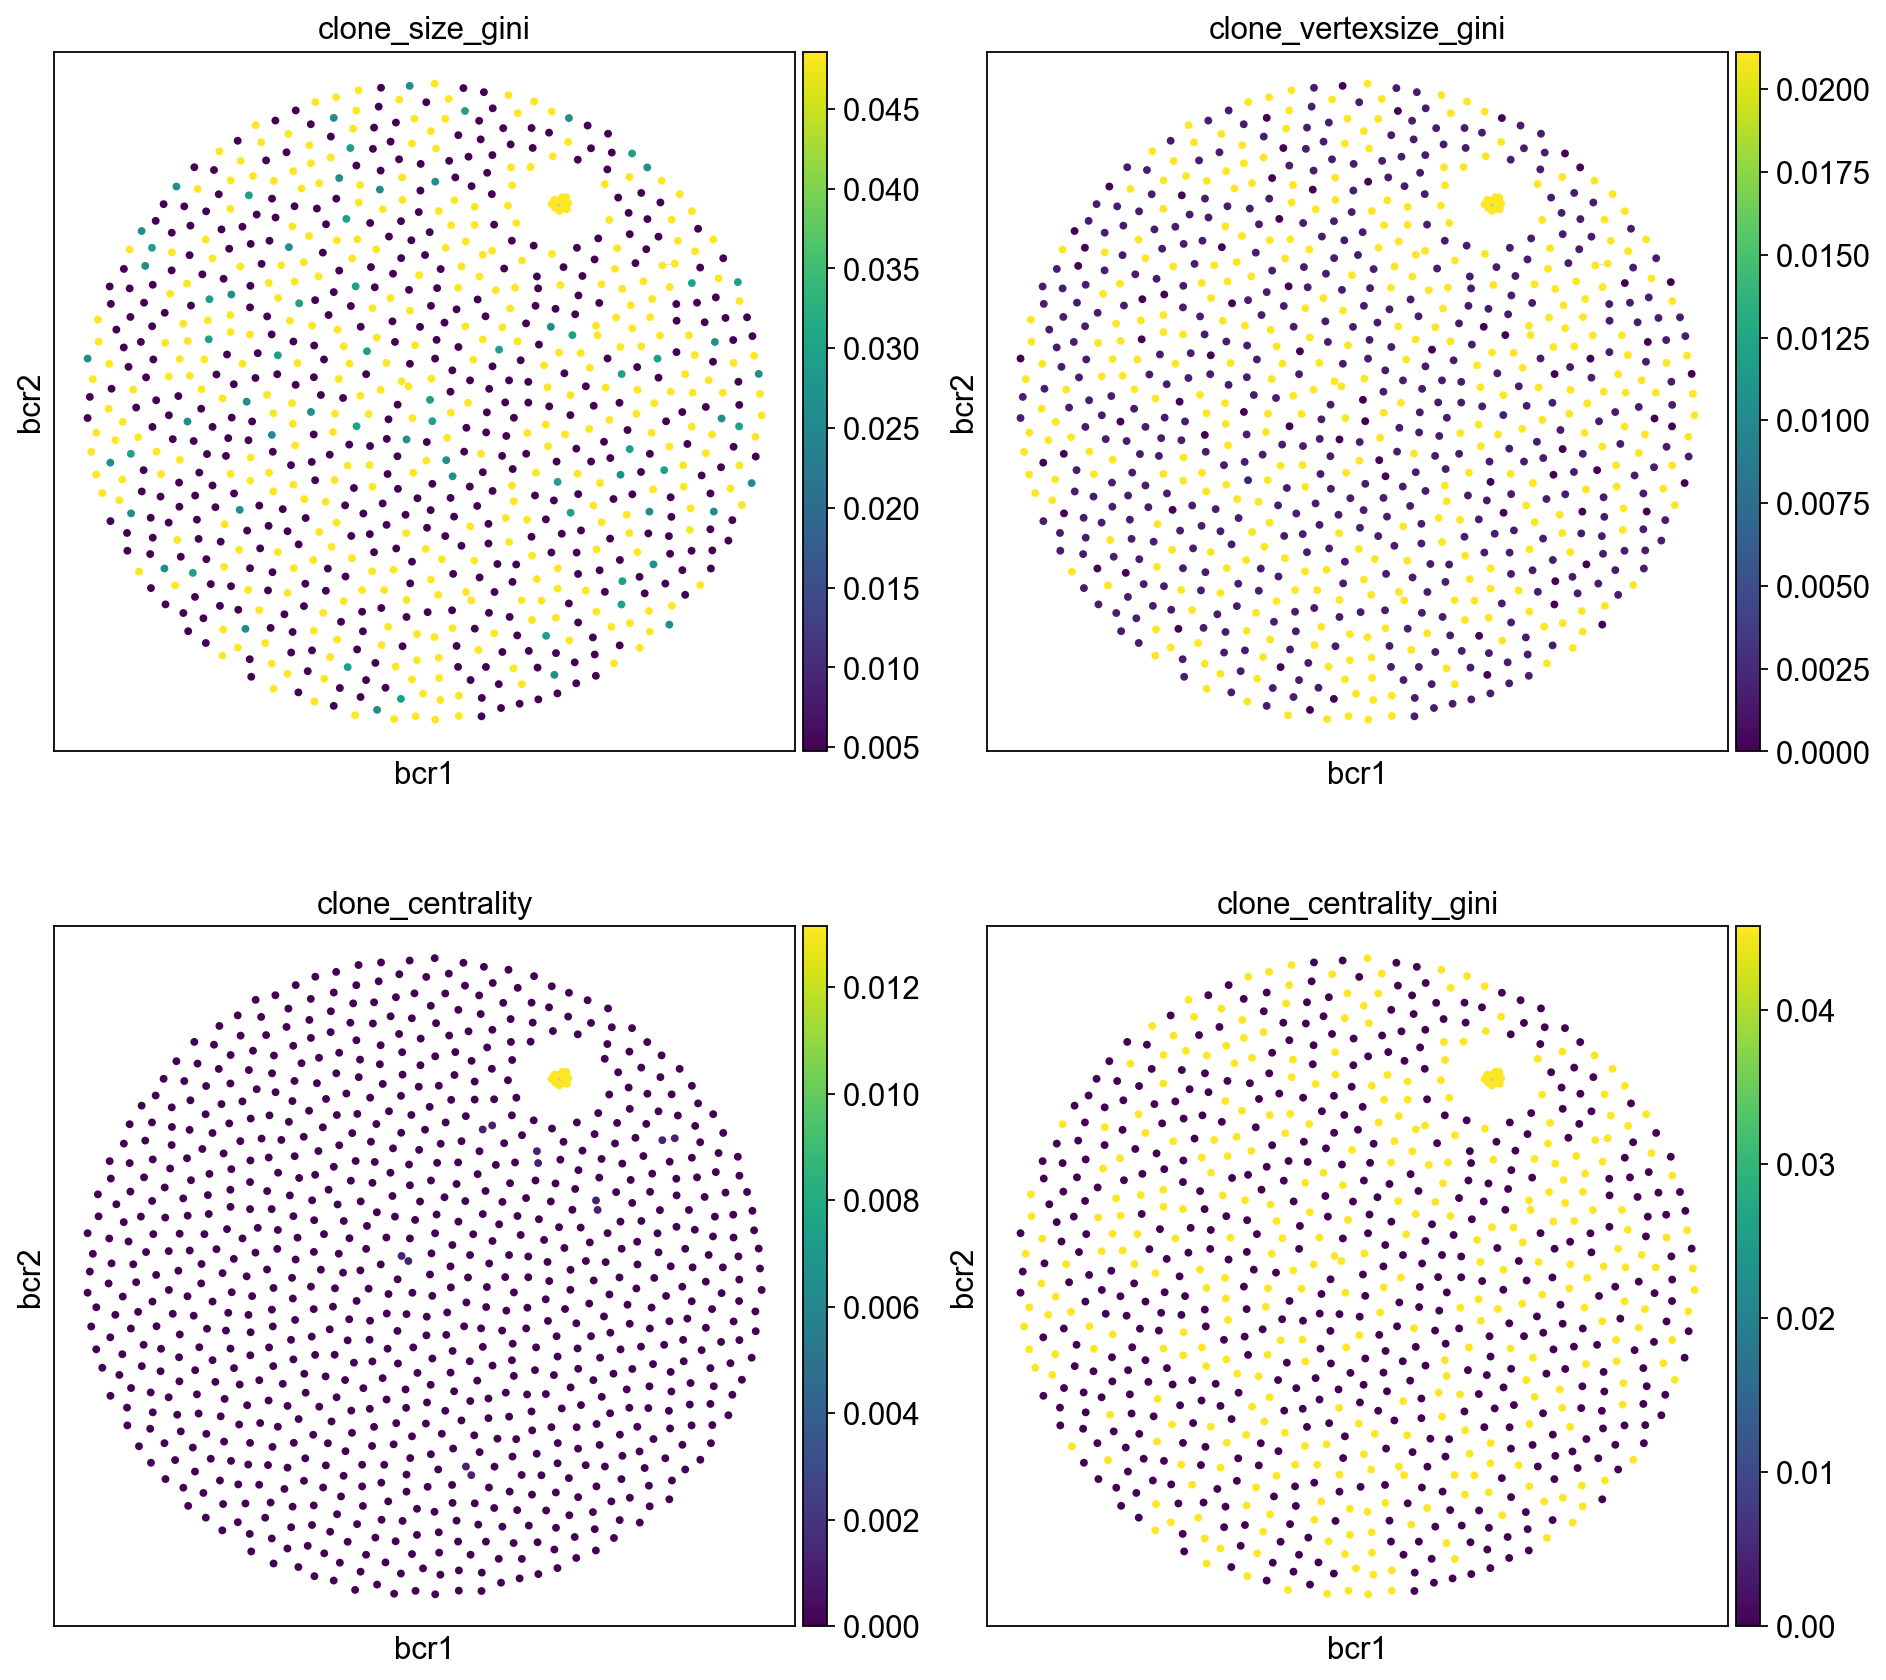

In [41]:
ddl.pl.clone_network(adata, color = ['clone_size_gini', 'clone_vertexsize_gini', 'clone_centrality', 'clone_centrality_gini'], ncols = 2, size = 50)

In [42]:
gini = ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'gini', update_obs_meta=False)
gini

Calculating Gini indices
Dandelion provided. Computing Gini indices for clone size and clone network.
 finished (0:00:12)


clone_size_gini  clone_vertexsize_gini
sc5p_v2_hs_PBMC_10k          0.004739               0.001584
vdj_v1_hs_pbmc3              0.026316               0.000000
sc5p_v2_hs_PBMC_1k           0.029412               0.000000
vdj_nextgem_hs_pbmc3         0.048583               0.021134

<AxesSubplot:xlabel='clone_size_gini', ylabel='clone_vertexsize_gini'>

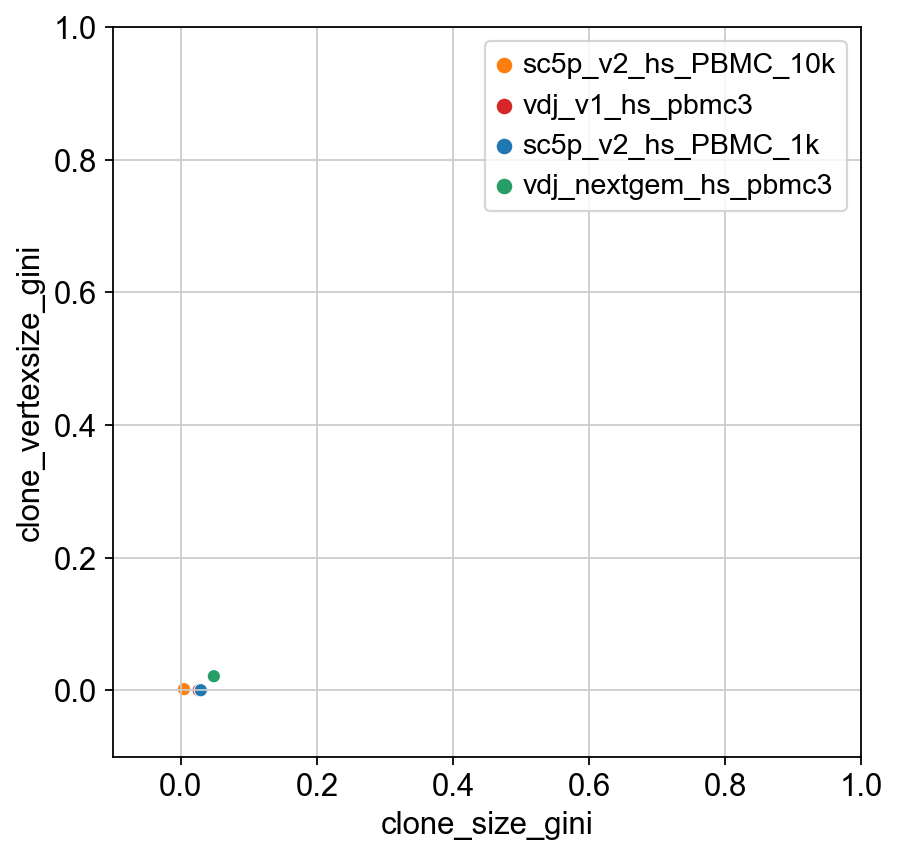

In [43]:
import seaborn as sns
# not a great example because there's only 1 big clone in 1 sample. will 
p = sns.scatterplot(x = 'clone_size_gini', y = 'clone_vertexsize_gini', data = gini, hue = gini.index, palette = dict(zip(adata.obs['sampleid'].cat.categories, adata.uns['sampleid_colors'])))
p.set(ylim=(-0.1,1), xlim = (-0.1,1))
p

In [44]:
gini = ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'gini', metric = 'clone_centrality', update_obs_meta=False)
gini

Calculating Gini indices
Dandelion provided. Computing Gini indices for clone size and clone network.
Calculating node closeness centrality
 finished: Updated Dandelion metadata
 (0:00:00)
 finished (0:00:01)


clone_size_gini  clone_centrality_gini
sc5p_v2_hs_PBMC_10k          0.004739               0.000000
vdj_v1_hs_pbmc3              0.026316               0.000000
sc5p_v2_hs_PBMC_1k           0.029412               0.000000
vdj_nextgem_hs_pbmc3         0.048583               0.045455

<AxesSubplot:xlabel='clone_size_gini', ylabel='clone_centrality_gini'>

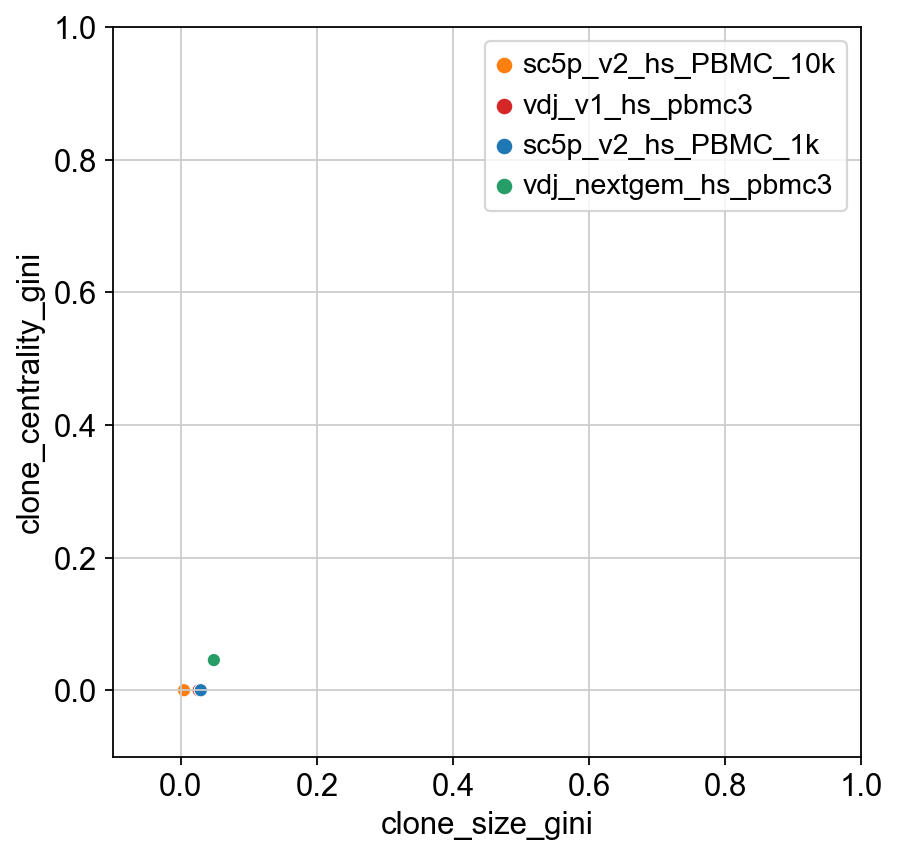

In [45]:
# not a great example because there's only 1 big clone in 1 sample.
p = sns.scatterplot(x = 'clone_size_gini', y = 'clone_centrality_gini', data = gini, hue = gini.index, palette = dict(zip(adata.obs['sampleid'].cat.categories, adata.uns['sampleid_colors'])))
p.set(ylim=(-0.1,1), xlim = (-0.1,1))
p

Chao1 is an estimator based on abundance

In [46]:
ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'chao1', update_obs_meta = False)

Calculating Chao1 estimates
 finished (0:00:01)


clone_size_chao1
sc5p_v2_hs_PBMC_10k            44205.5
vdj_v1_hs_pbmc3                  703.0
sc5p_v2_hs_PBMC_1k               561.0
vdj_nextgem_hs_pbmc3            9106.0

For Shannon Entropy, we can calculate a normalized (inspired by `scirpy`'s [function](https://icbi-lab.github.io/scirpy/generated/scirpy.tl.alpha_diversity.html?highlight=diversity#scirpy.tl.alpha_diversity)) and non-normalized value.

In [47]:
ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'shannon', update_obs_meta = False)

Calculating Shannon entropy
 finished (0:00:01)


clone_size_normalized_shannon
sc5p_v2_hs_PBMC_10k                        0.999849
vdj_v1_hs_pbmc3                            1.000000
sc5p_v2_hs_PBMC_1k                         1.000000
vdj_nextgem_hs_pbmc3                       0.989883

In [48]:
ddl.tl.clone_diversity(vdj, groupby = 'sample_id', method = 'shannon', update_obs_meta = False, normalize = False)

Calculating Shannon entropy
 finished (0:00:01)


clone_size_shannon
sc5p_v2_hs_PBMC_10k             8.712926
vdj_v1_hs_pbmc3                 5.209453
sc5p_v2_hs_PBMC_1k              5.044394
vdj_nextgem_hs_pbmc3            8.285998

In [49]:
adata

AnnData object with n_obs × n_vars = 16492 × 1497
    obs: 'sampleid', 'batch', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'leiden', 'sample_id', 'clone_id', 'clone_id_by_size', 'isotype', 'lightchain', 'status', 'vdj_status', 'productive', 'umi_counts_heavy', 'umi_counts_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'changeo_clone_id', 'clone_id_heavyonly', 'junction_aa_heavy', 'junction_aa_light', 'mu_freq', 'mu_freq_seq_r', 'mu_freq_seq_s', 'mu_freq_seq_r_IGK', 'mu_freq_seq_s_IGK', 'mu_freq_IGK', 'mu_freq_seq_r_IGH', 'mu_freq_seq_s_IGH', 'mu_freq_IGH', 'mu_freq_seq_r_IGL', 'mu_freq_seq_s_IGL', 'mu_freq_IGL', 'clone_id_size', 'clone_id_size_max_3', 'clone_size_gini', 'clone_vertexsize_gini', 'clone_centrality', 'clone_centrality_gini'
    var: 'feature_types', 'genome', 'gene_ids-0', '

## Additional plotting functions

## *barplot*
`pl.barplot` is a generic barplot function that will plot items in the metadata slot as a bar plot. This function will also interact with `.obs` slot if a `scanpy` object is used in place of `Dandelion` object. However, if your `scanpy` object holds a lot of non-B cells, then the plotting will be just be saturated with nan values.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='proportion'>)

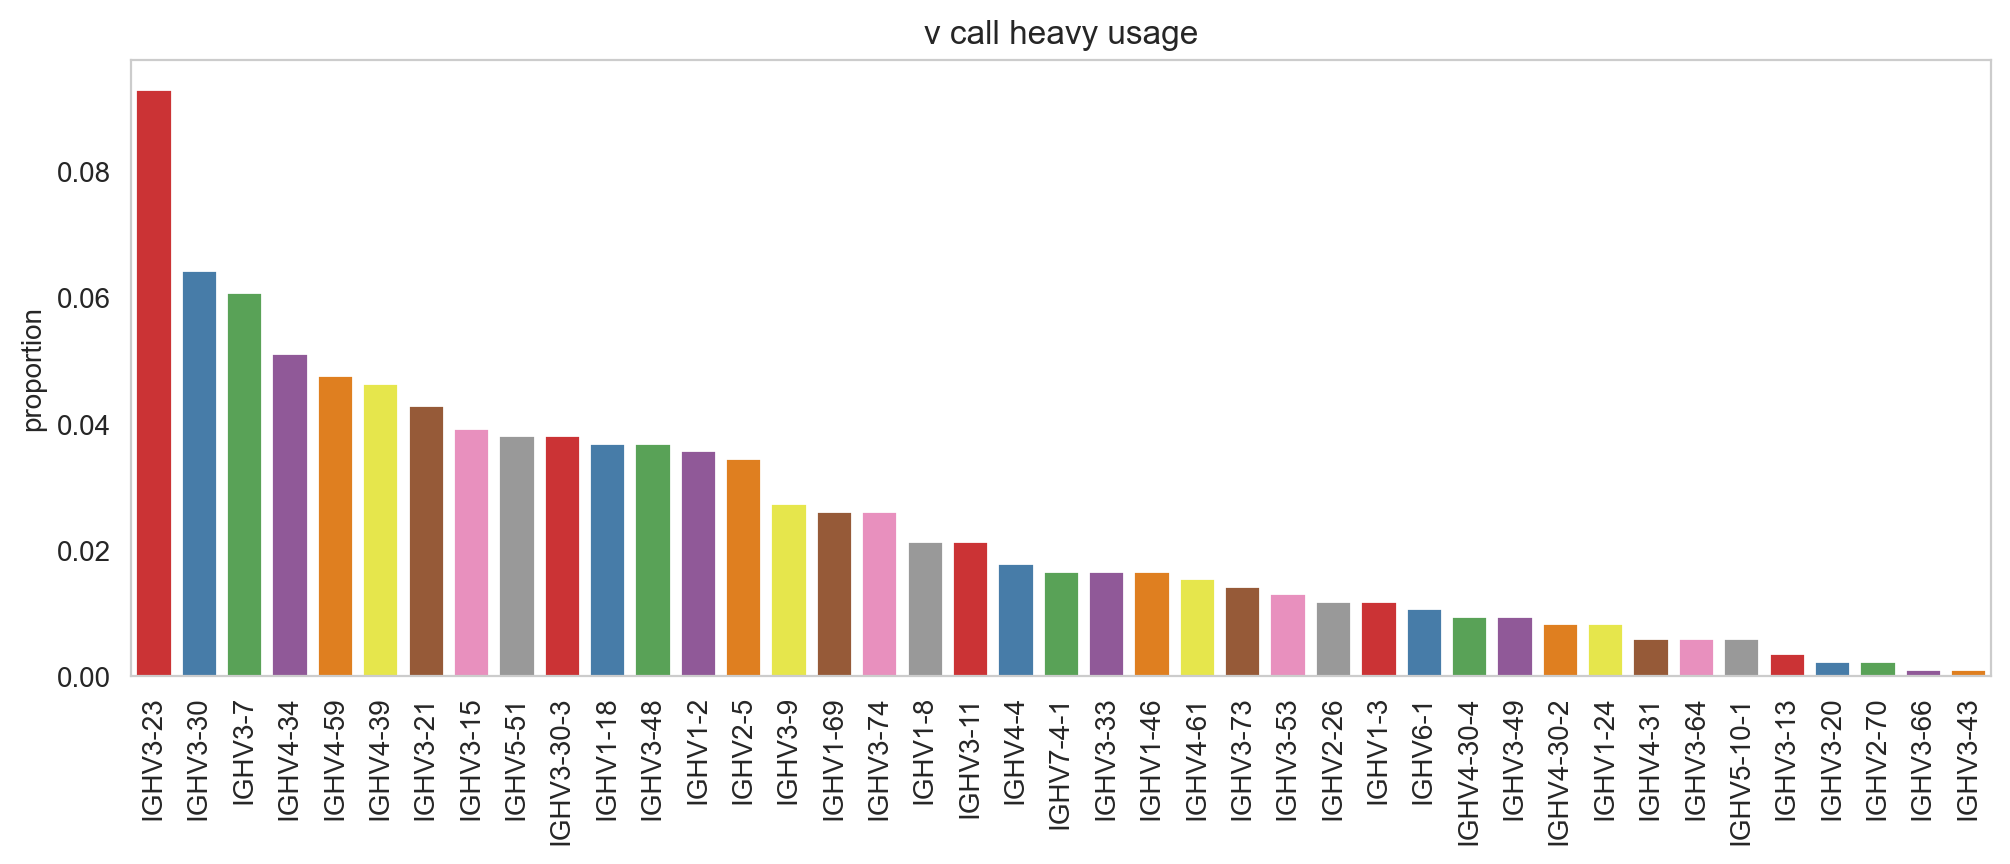

In [50]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
ddl.pl.barplot(vdj, variable = 'v_call_heavy', figsize = (12, 4))

You can prevent it from sorting by specifying `sort_descending = None`. Colours can be changed with `palette` option.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='proportion'>)

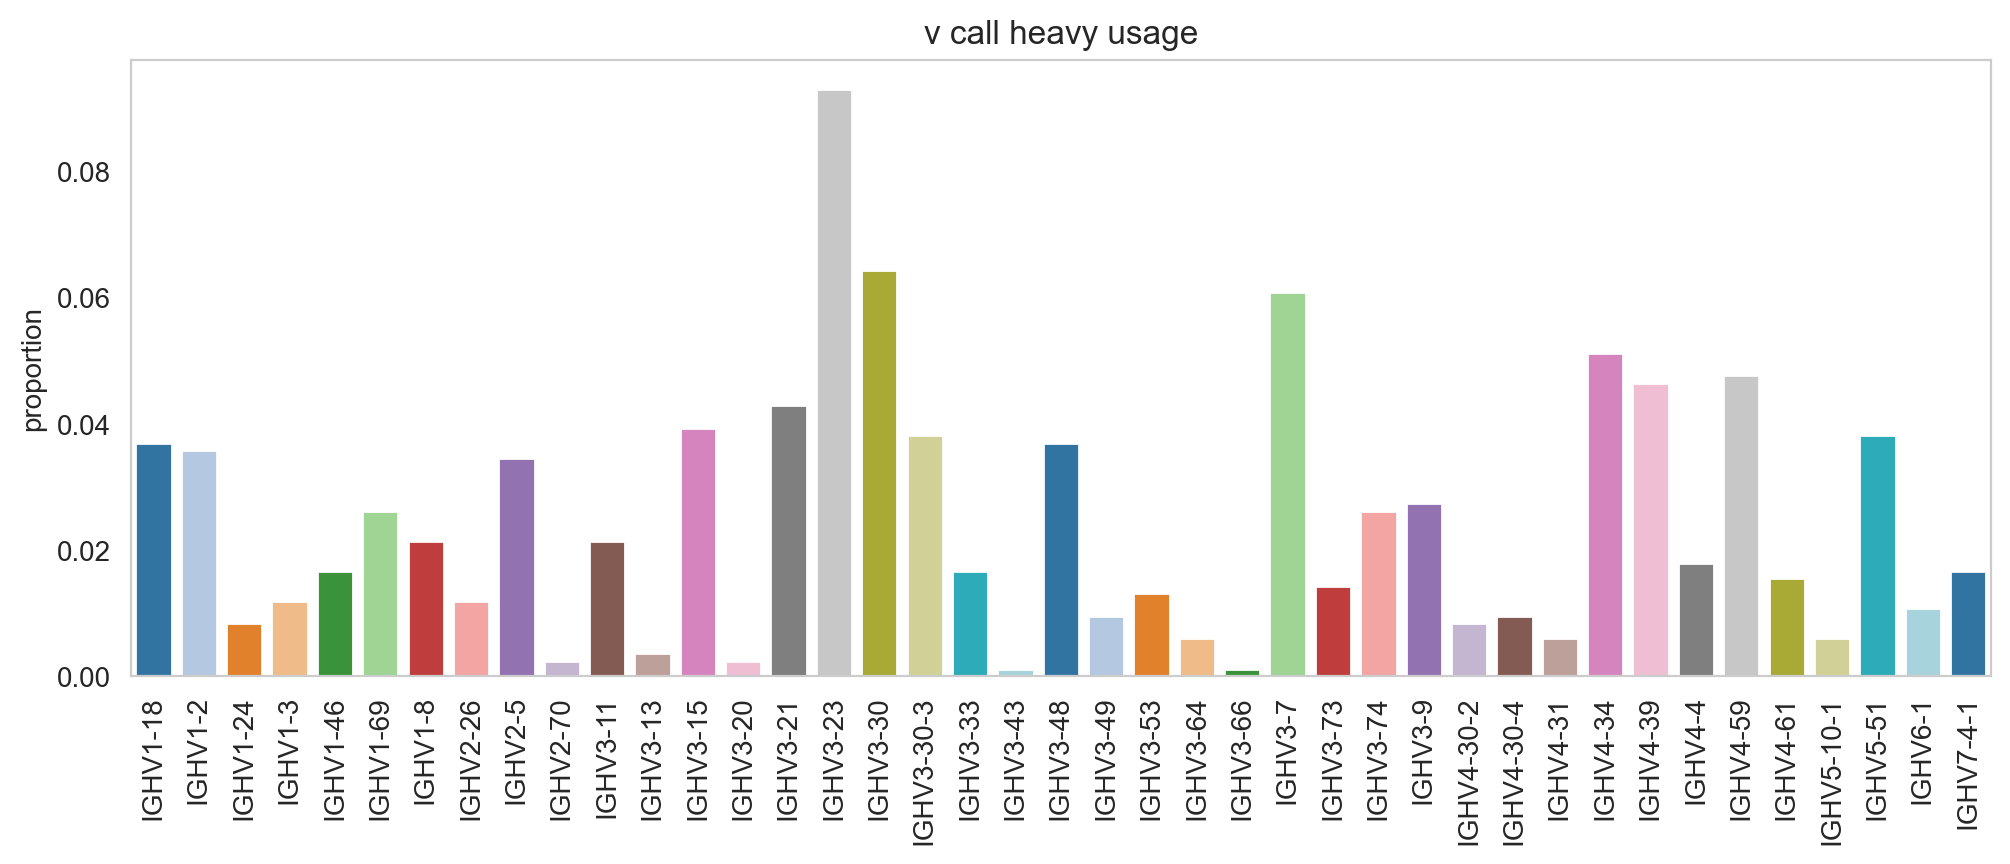

In [51]:
ddl.pl.barplot(vdj, variable = 'v_call_heavy', figsize = (12, 4), sort_descending = None, palette = 'tab20')

Specifying `normalize = False` will change the y-axis to counts.

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:title={'center':'v call heavy usage'}, ylabel='count'>)

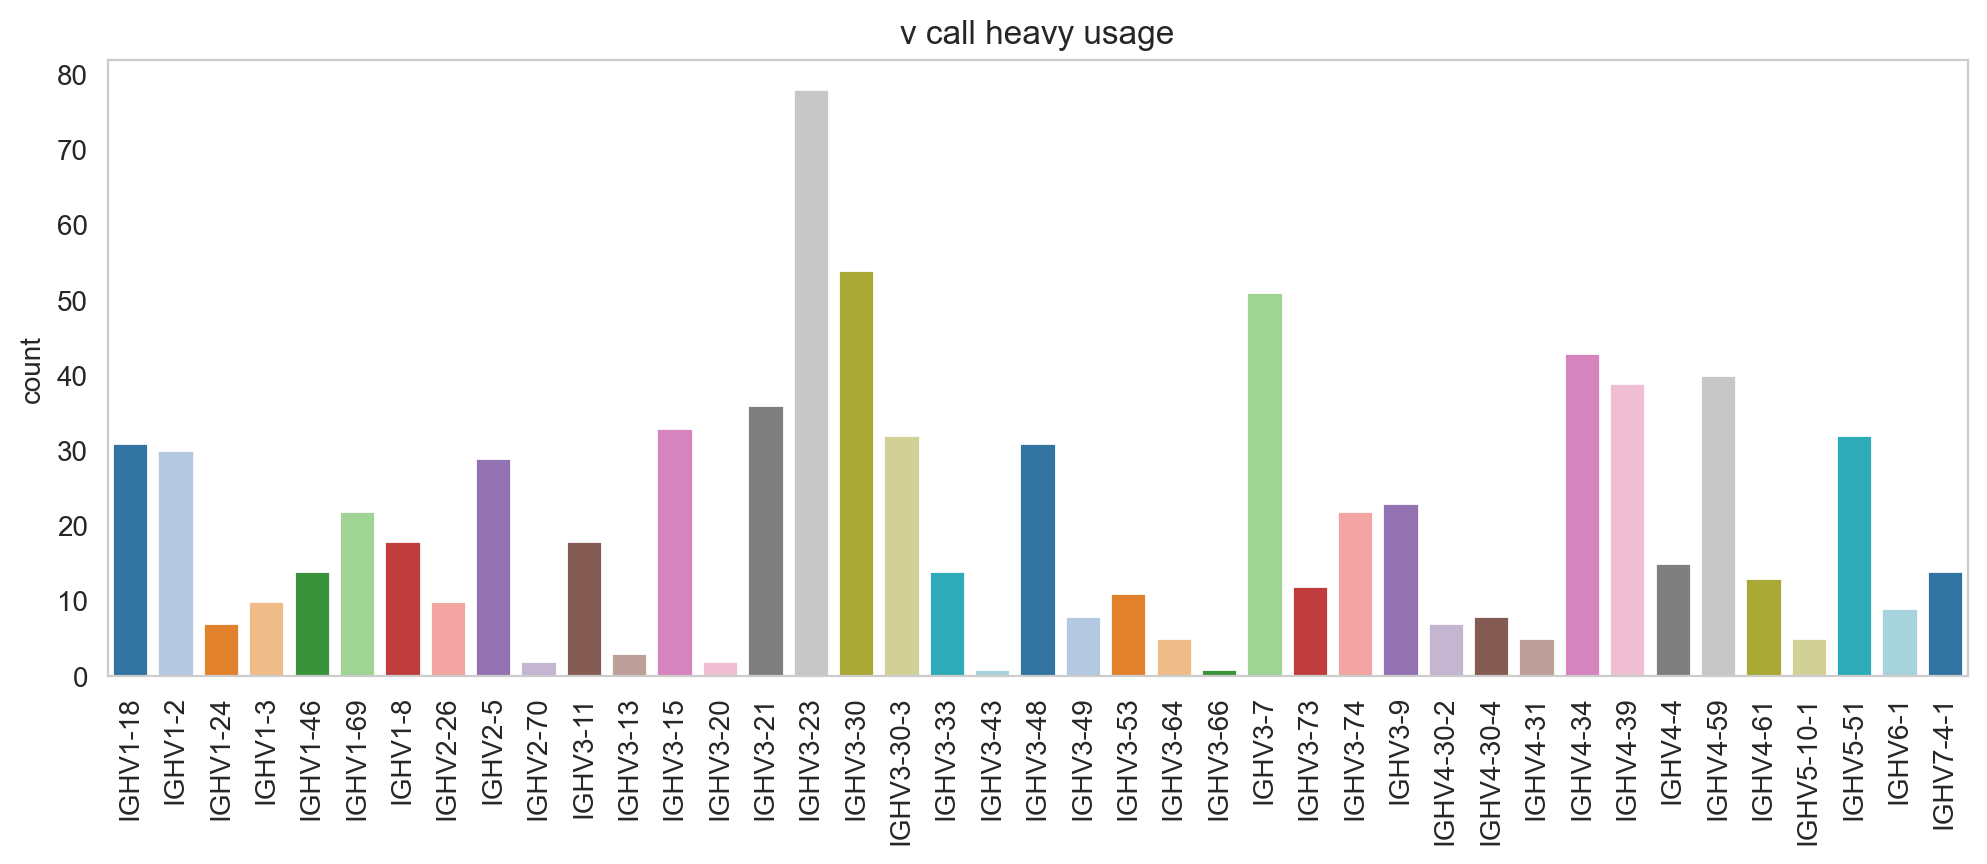

In [52]:
ddl.pl.barplot(vdj, variable = 'v_call_heavy', normalize = False, figsize = (12, 4), sort_descending = None, palette = 'tab20')

## *stackedbarplot*
`pl.stackedbarplot` is similar to above but can split between specified groups. Some examples below:

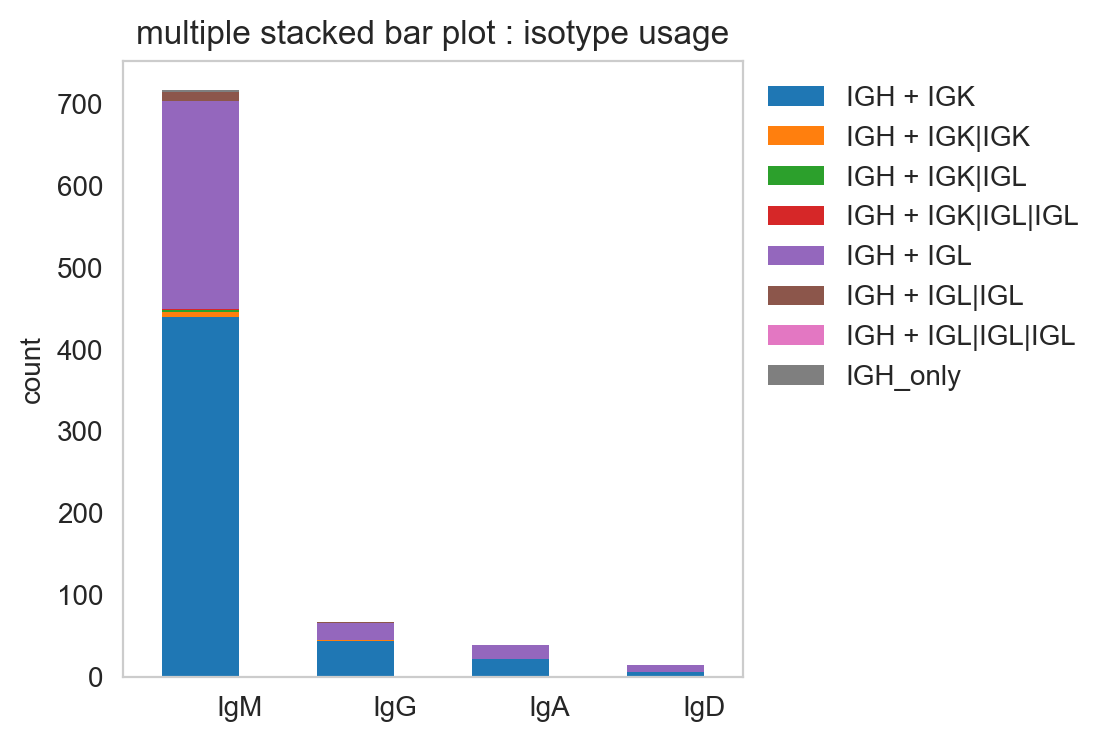

In [53]:
import matplotlib.pyplot as plt
ddl.pl.stackedbarplot(vdj, variable = 'isotype', groupby = 'status', xtick_rotation =0, figsize = (4,4))
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

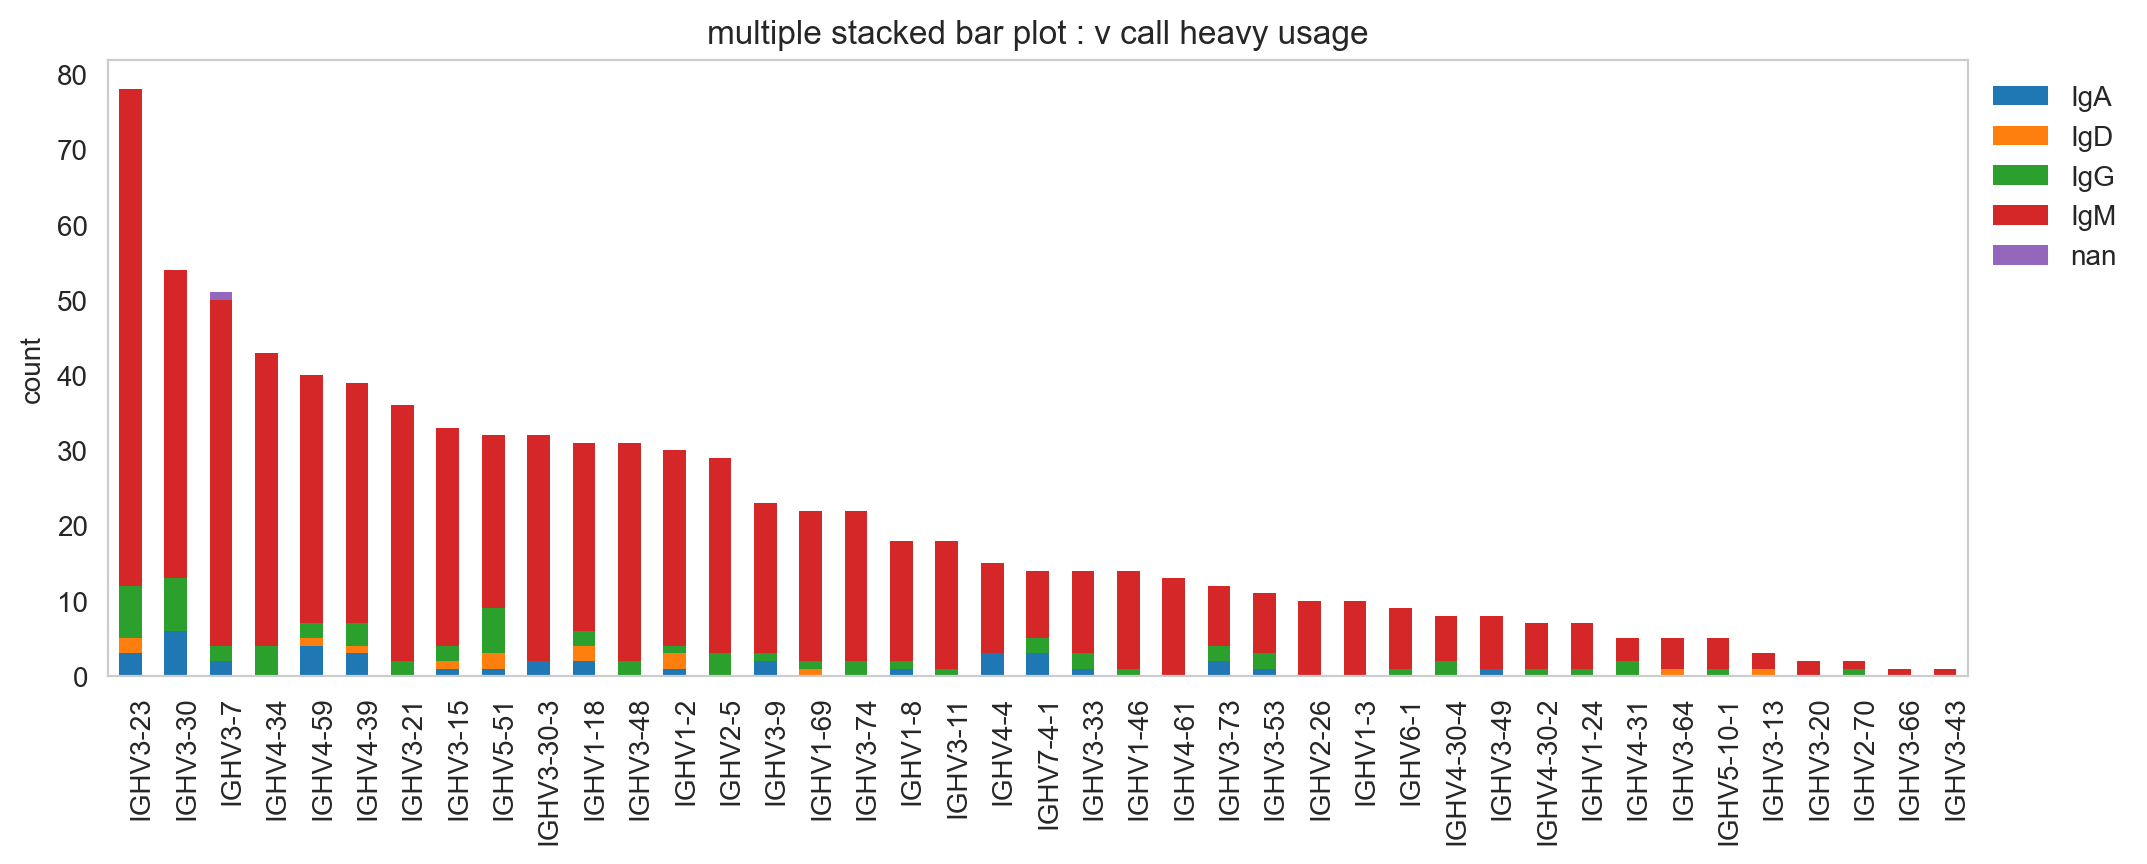

In [54]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_heavy', groupby = 'isotype')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

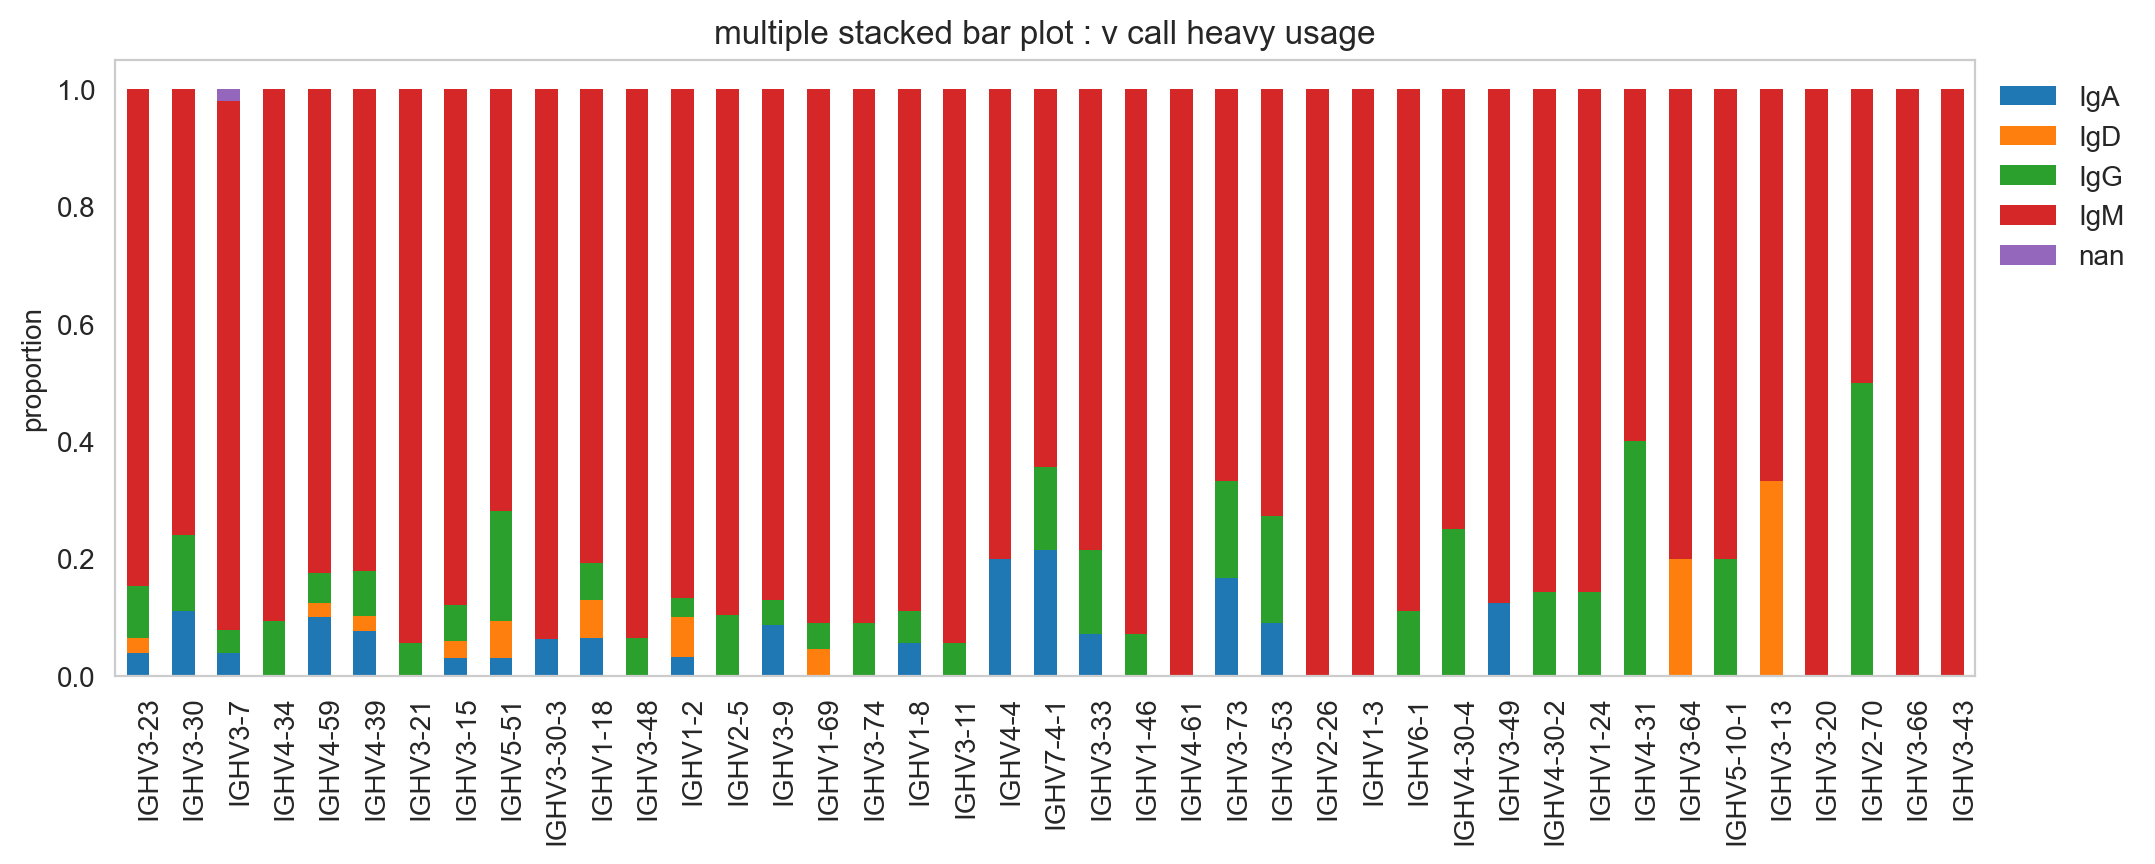

In [55]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_heavy', groupby = 'isotype', normalize = True)
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

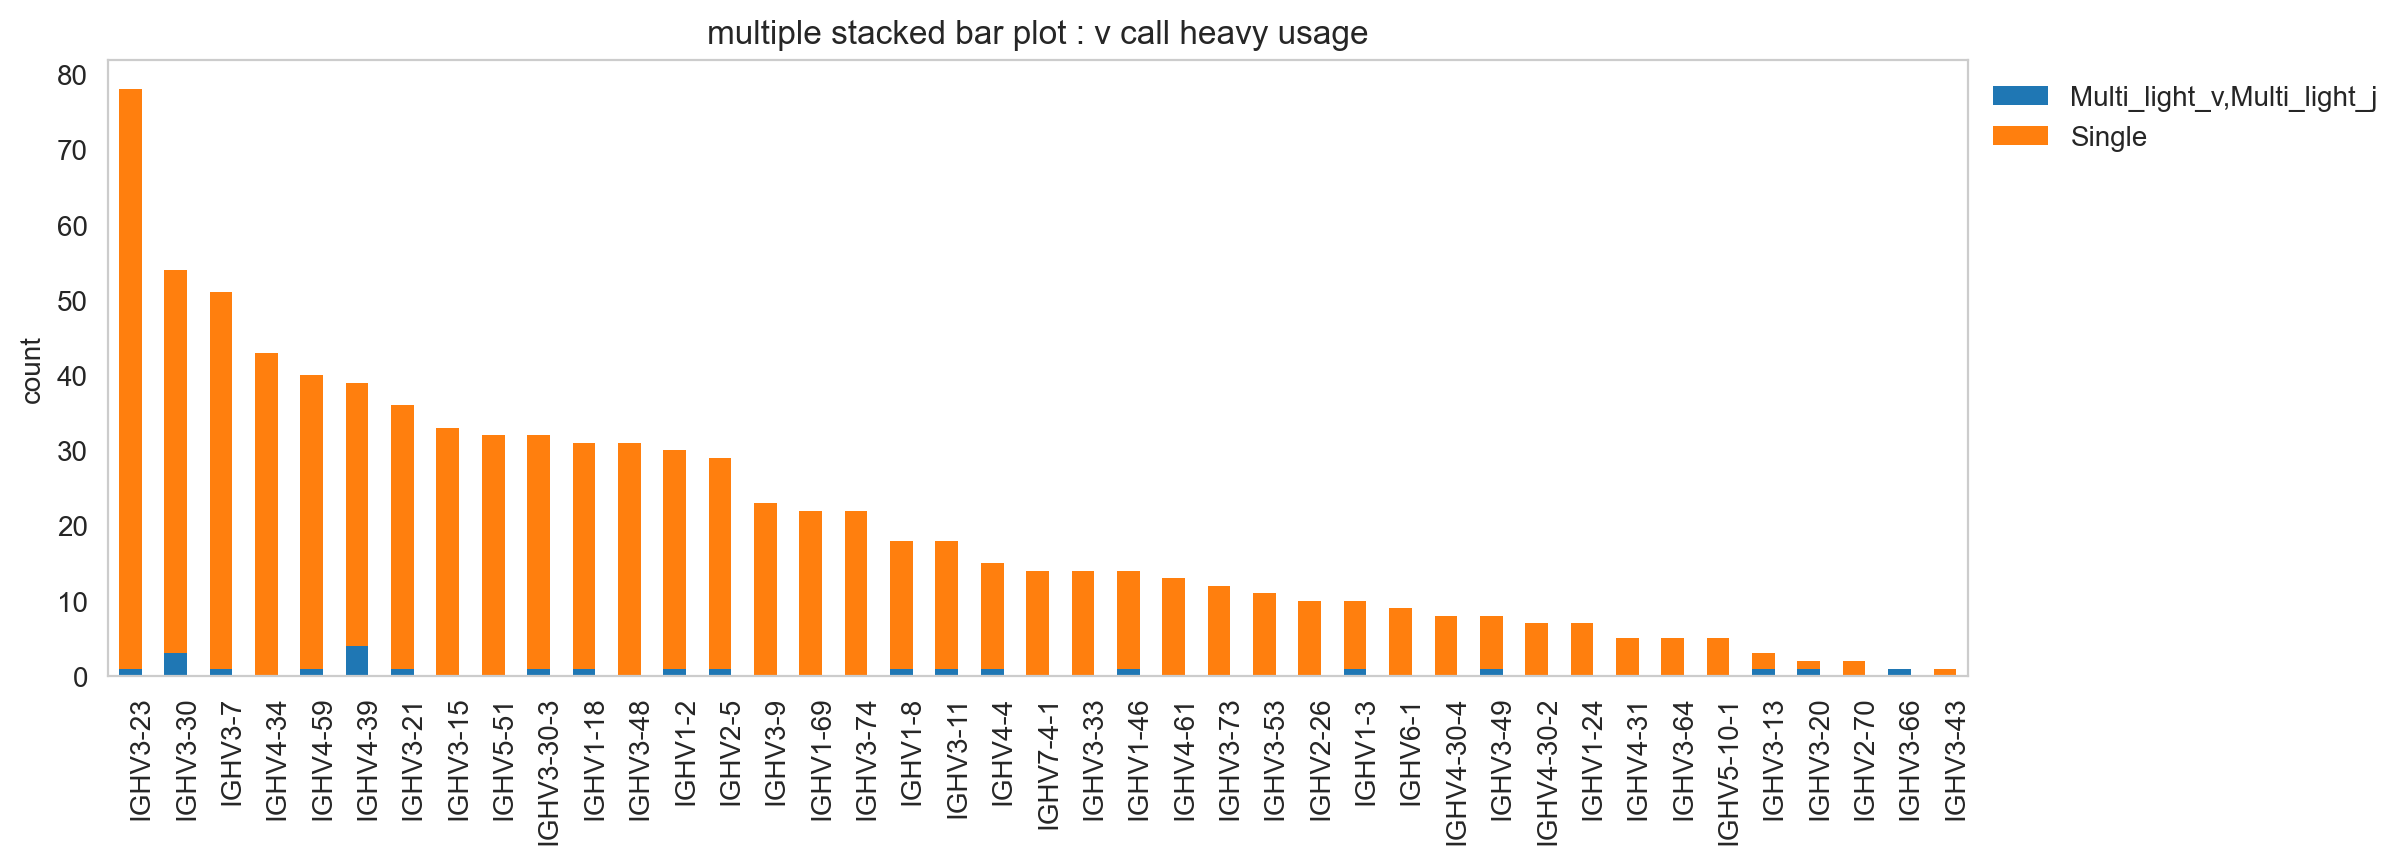

In [56]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_heavy', groupby = 'vdj_status')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

It's obviously more useful if you don't have too many groups, but you could try and plot everything and jiggle the legend options and color.

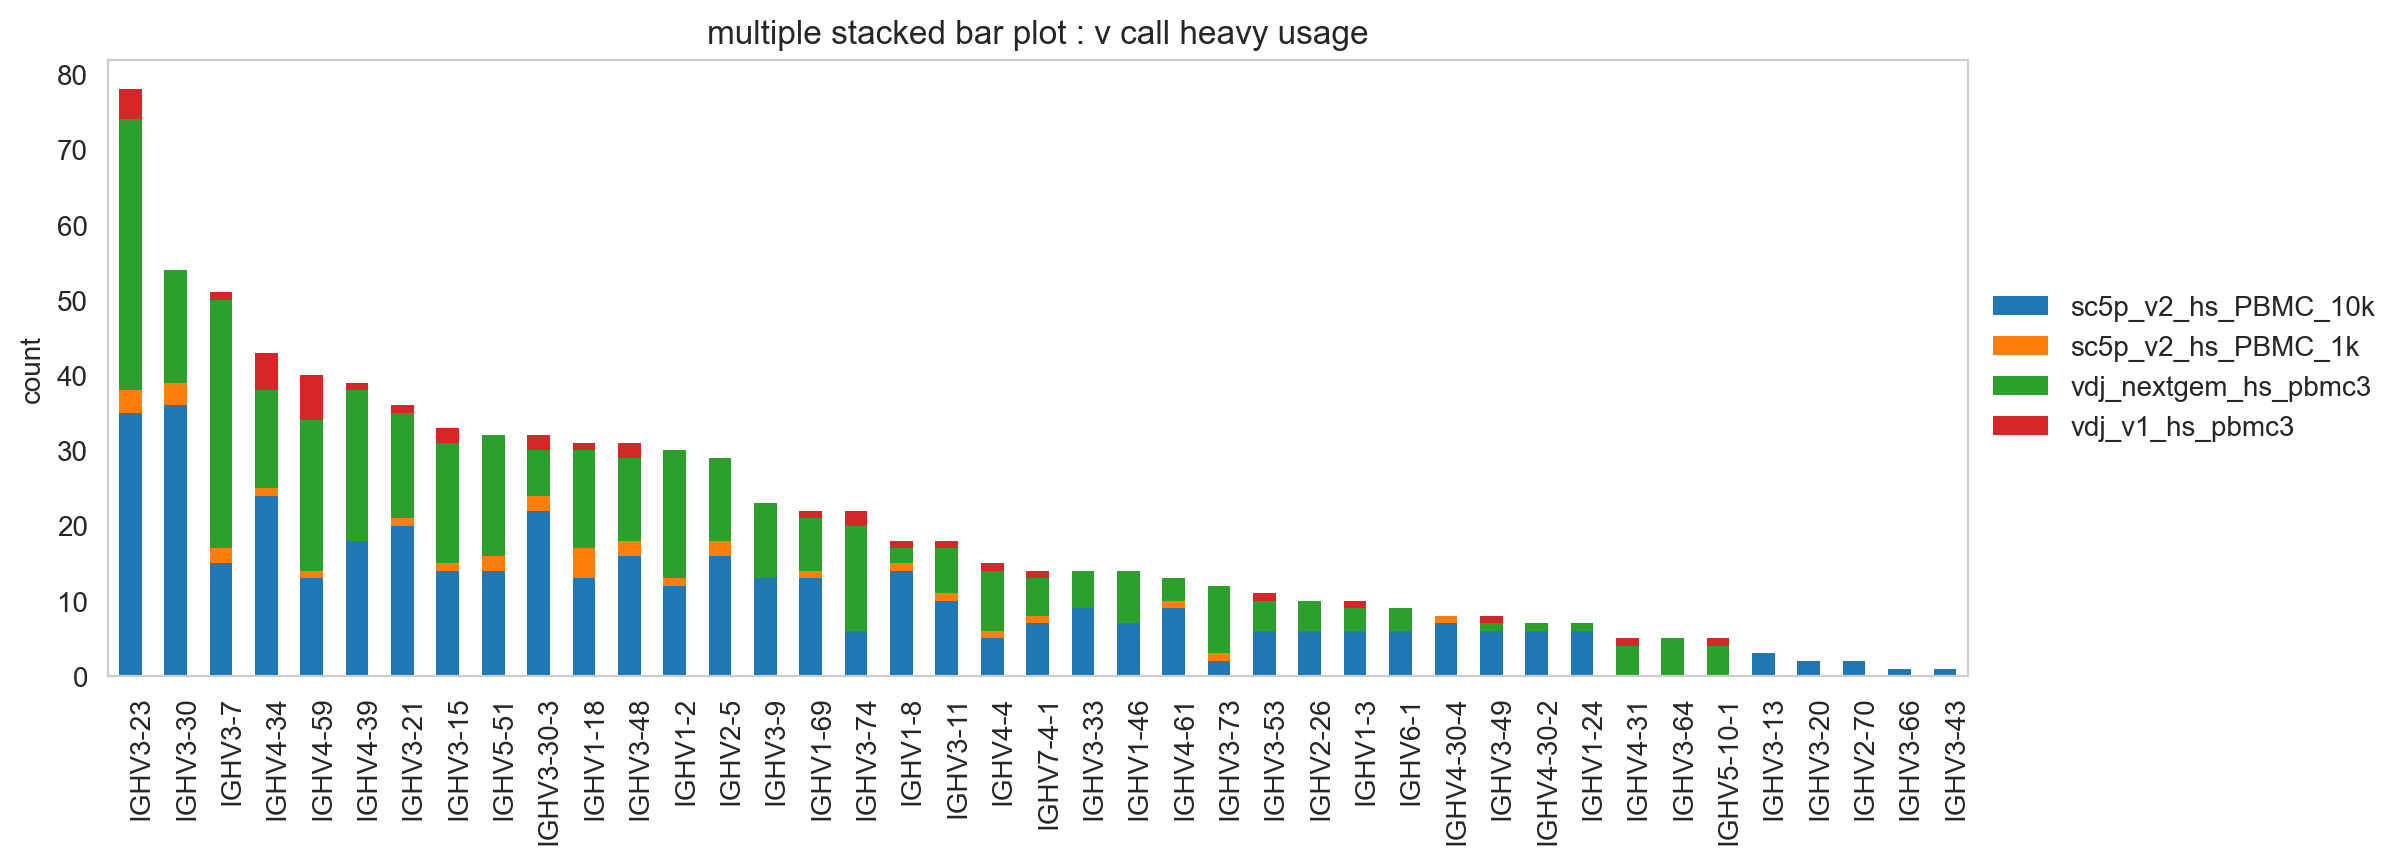

In [57]:
ddl.pl.stackedbarplot(vdj, variable = 'v_call_heavy', groupby = 'sample_id')
plt.legend(bbox_to_anchor = (1, 0.5), loc='center left', frameon=False)

## *spectratype*
Spectratype plots contain info displaying CDR3 length distribution for specified groups. For this function, the current method only works for `dandelion` objects as it requires access to the contig-indexed *.data* slot.

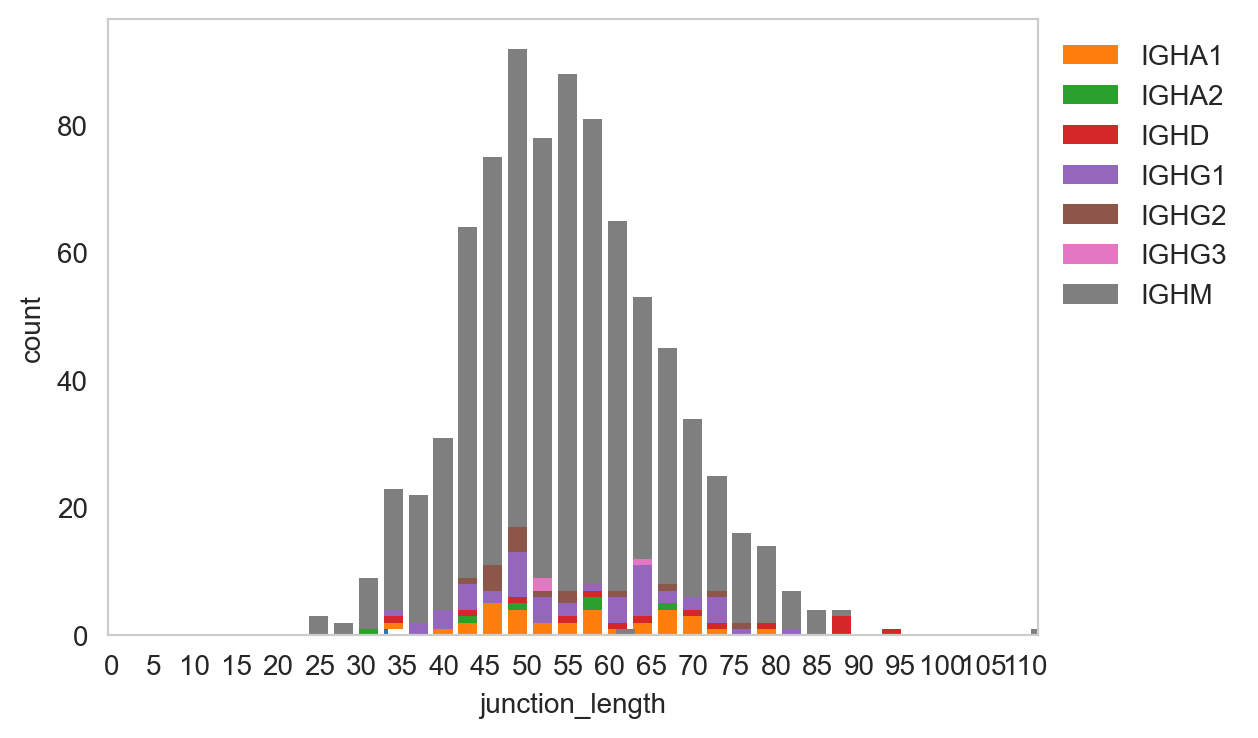

In [58]:
ddl.pl.spectratype(vdj, variable = 'junction_length', groupby = 'c_call', locus='IGH', width = 2.3)
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

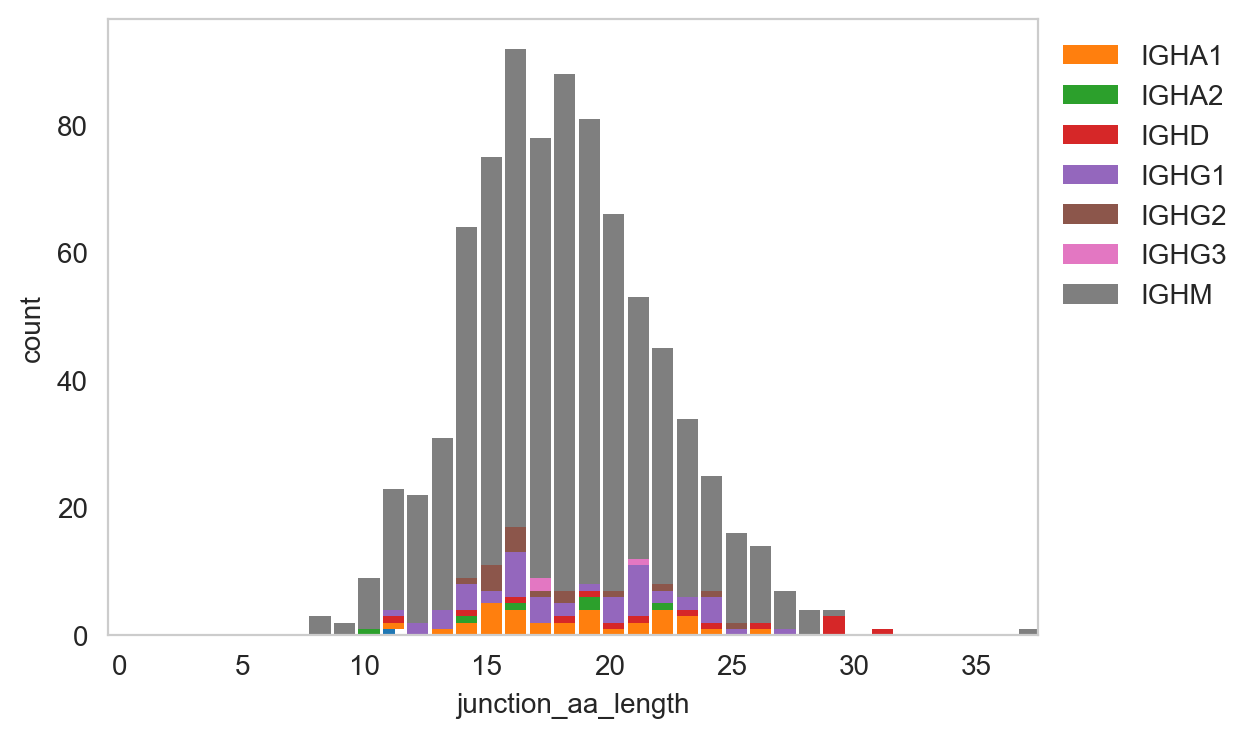

In [59]:
ddl.pl.spectratype(vdj, variable = 'junction_aa_length', groupby = 'c_call', locus='IGH')
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

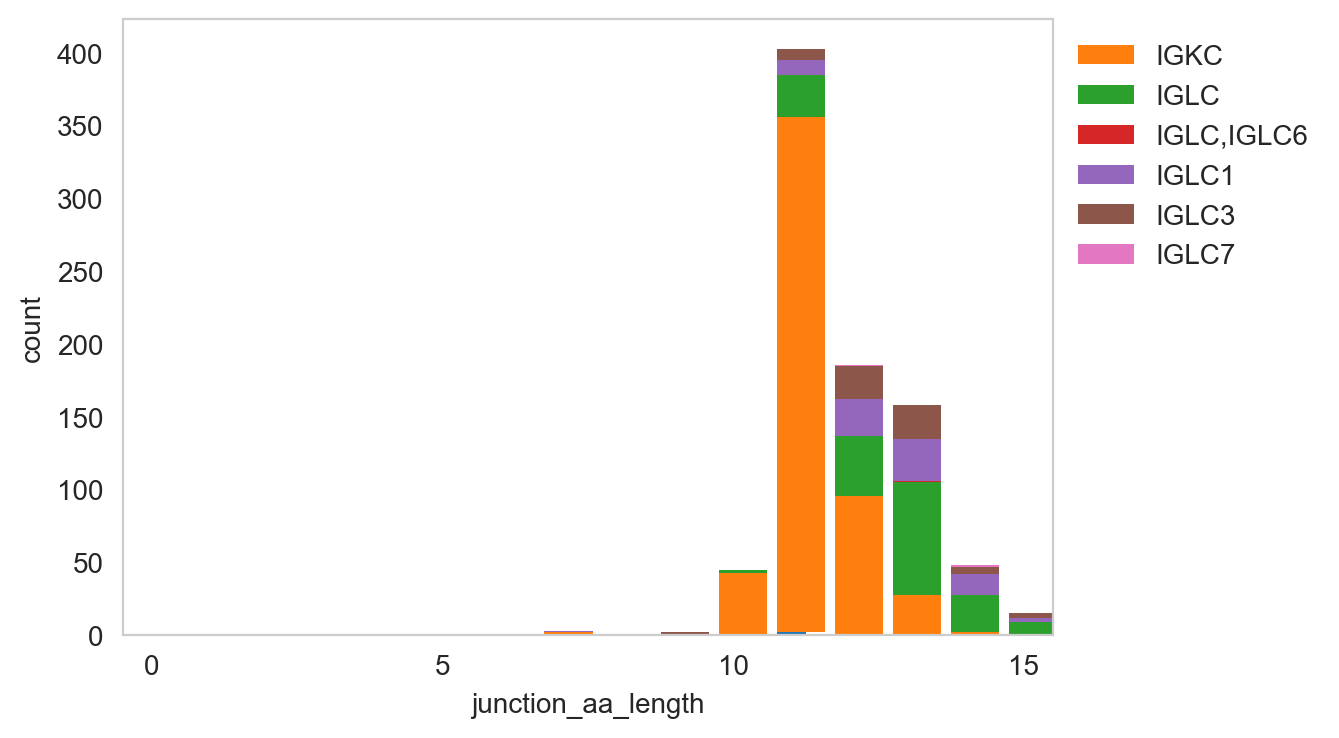

In [60]:
ddl.pl.spectratype(vdj, variable = 'junction_aa_length', groupby = 'c_call', locus=['IGK','IGL'])
plt.legend(bbox_to_anchor = (1,1), loc='upper left', frameon=False)

## *clone_overlap*
There is now a circos-style clone overlap function where it looks for whather different samples share a clone. If they do, an arc/connection will be drawn between them. This requires the python module `nxviz` to be installed; at the writing of this notebook, there are some dependencies issues with `pip install nxviz`, therefore I've adjusted the requirements in a forked repository which you can install via: `pip install git+https://github.com/zktuong/nxviz.git`

In [61]:
ddl.tl.clone_overlap(adata, groupby = 'leiden', colorby = 'leiden')

Finding clones
 finished: Updated AnnData: 
   'uns', clone overlap table (0:00:00)


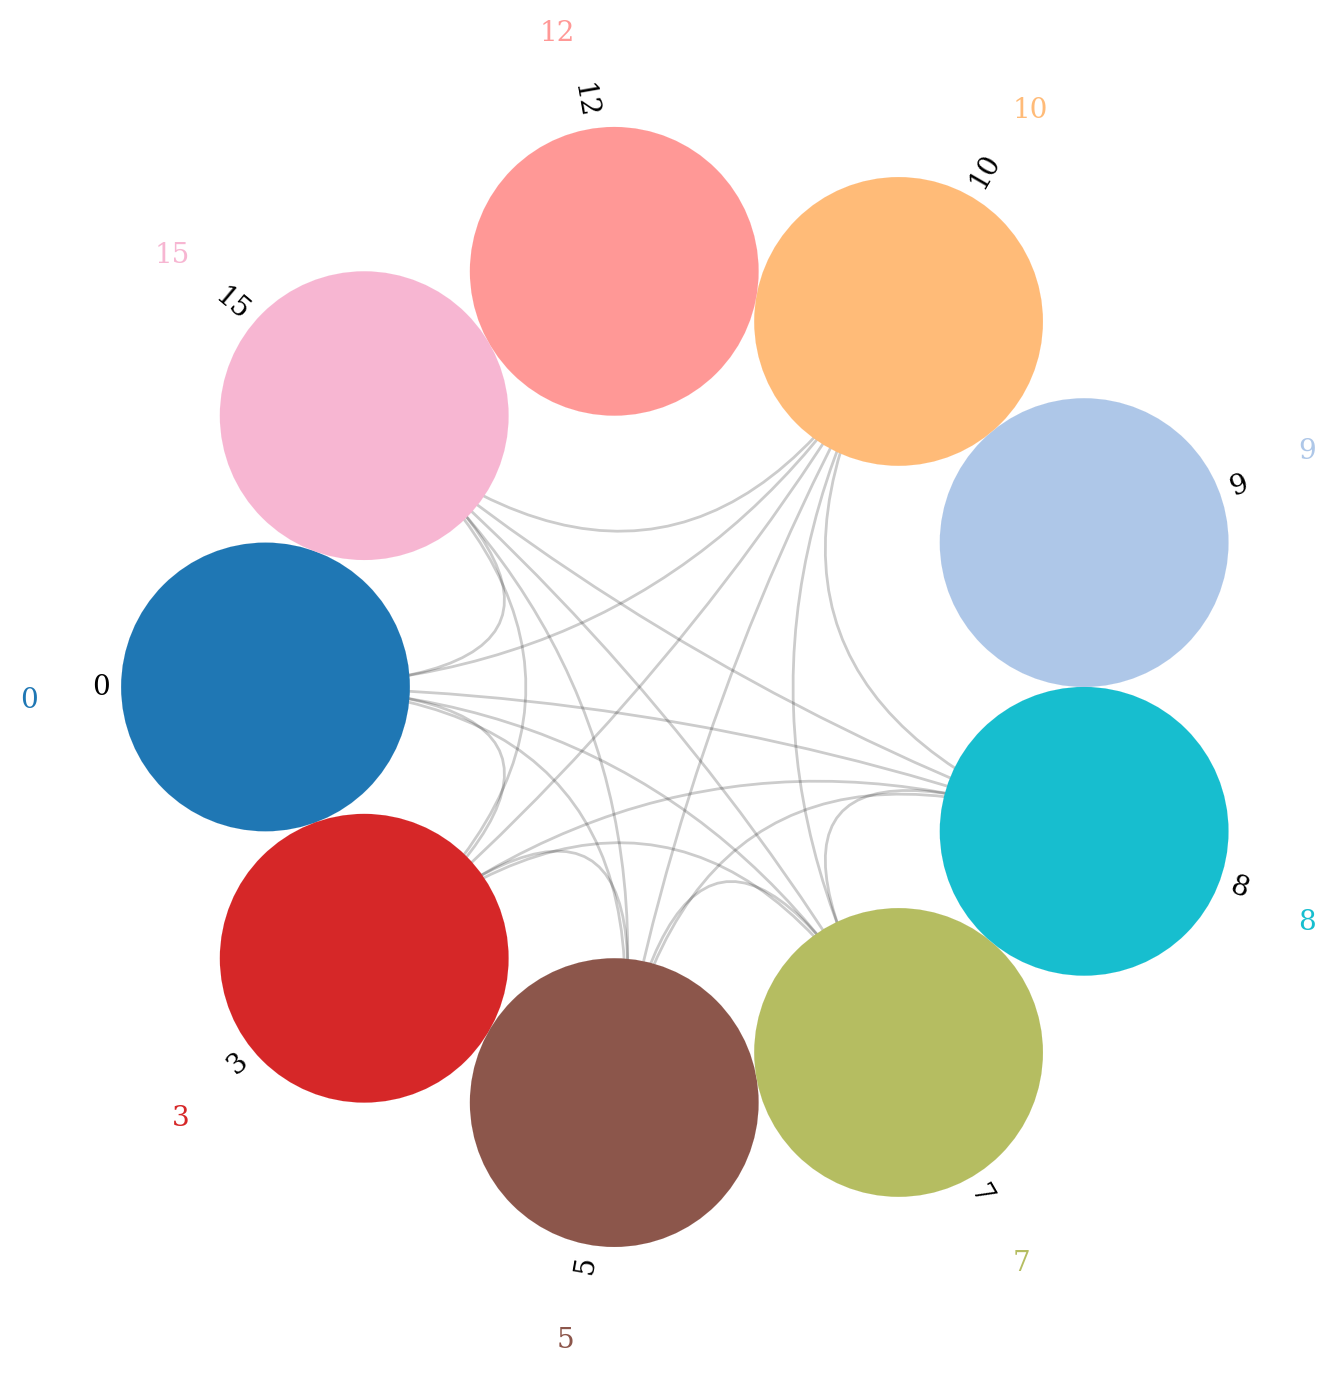

In [62]:
ddl.pl.clone_overlap(adata, groupby = 'leiden', colorby = 'leiden', return_graph=True, group_label_offset=.5)

Other use cases for this would be, for example, to plot nodes as individual samples and the colors as group classifications of the samples. As long as this information is found in the `.obs` column in the `AnnData`, or even `Dandelion.metadata`, this will work.

That sums it up for now! Let me know if you have any ideas at [kt16@sanger.ac.uk] and I can try and see if i can implement it or we can work something out to collaborate on!